# AI-based IDS for Resource-Constrained IoT (TON_IoT) — Fixed & Colab-Ready

This notebook implements a complete, reproducible PyTorch pipeline (teacher, SHAP-based pruning, Kronecker-compressed student, knowledge distillation, dynamic quantization, benchmarking). It addresses previously reported issues: robust SHAP conversion, consistent feature selection, Kronecker shapes, KD training without double selection, and quantization fallback when best_conf is unavailable.

## Drive configuration

In [ ]:
# =========================
# 0) Google Drive mount & paths
# =========================
import os
from pathlib import Path

IN_COLAB = 'google.colab' in str(get_ipython())
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

# Set dataset path (edit if needed)
DATA_PATH = '/content/drive/MyDrive/Datasets/train_test_network.csv'

BASE_DRIVE_DIR = Path('/content/drive/MyDrive/Datasets/TON_IoT_Experiments')

# Fallbacks if path not found
if not os.path.exists(DATA_PATH):
    alt1 = '/content/train_test_network.csv'
    alt2 = '/mnt/data/train_test_network.csv'
    if os.path.exists(alt1):
        DATA_PATH = alt1
    elif os.path.exists(alt2):
        DATA_PATH = alt2

print('Using DATA_PATH =', DATA_PATH)
print('Artifacts base dir =', BASE_DRIVE_DIR)

Mounted at /content/drive
Using DATA_PATH = /content/drive/MyDrive/Datasets/train_test_network.csv
Artifacts base dir = /content/drive/MyDrive/Datasets/TON_IoT_Experiments


## Setup & logging

In [ ]:
# =========================
# 1) Environment & Reproducibility
# =========================
import os, sys, json, math, time, random, gc
from dataclasses import dataclass, asdict
from pathlib import Path
import numpy as np
import pandas as pd
from typing import Tuple, Dict, Any, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, accuracy_score, roc_auc_score, matthews_corrcoef
)
from sklearn.utils.class_weight import compute_class_weight
import joblib
import matplotlib.pyplot as plt

try:
    import shap
except Exception:
    import subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'shap', '-q'])
    import shap

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

from datetime import datetime
if 'BASE_DRIVE_DIR' not in globals():
    BASE_DRIVE_DIR = Path('./TON_IoT_Experiments')
BASE_DRIVE_DIR.mkdir(parents=True, exist_ok=True)

EXP_TIME = datetime.now().strftime("%Y%m%d_%H%M%S")
BASE_DIR = BASE_DRIVE_DIR / f'ids_experiment_{EXP_TIME}'
BASE_DIR.mkdir(exist_ok=True, parents=True)
LOG_PATH = BASE_DIR / 'logs.jsonl'
ARTIFACTS_DIR = BASE_DIR / 'artifacts'
ARTIFACTS_DIR.mkdir(exist_ok=True, parents=True)


def log_event(tag: str, payload: Dict[str, Any]):
    rec = {'time': time.time(), 'tag': tag, **payload}
    with open(LOG_PATH, 'a') as f:
        f.write(json.dumps(rec) + '\n')
    print(f"[LOG] {tag}: {list(payload.keys())}")

@dataclass
class HParams:
    batch_size: int = 1024
    lr: float = 1e-3
    weight_decay: float = 1e-3
    epochs: int = 50
    patience: int = 8
    dropout: float = 0.3
    use_focal: bool = False
    scheduler: str = 'cosine'  # {'step','cosine','none'}
    step_size: int = 10
    gamma: float = 0.5

# Instantiate hyperparameters
HP = HParams()
log_event('hparams', asdict(HP))

# Convert to DataFrame for visualization
hp_df = pd.DataFrame([asdict(HP)])
print("\nHyperparameters used:")
print(hp_df.T)  # Transposed for readability

# Save hyperparameters as CSV
hp_csv_path = BASE_DIR / "hyperparameters.csv"
hp_df.to_csv(hp_csv_path, index=False)
print(f"\nHyperparameters saved to: {hp_csv_path}")

print('Device:', DEVICE)


[LOG] hparams: ['batch_size', 'lr', 'weight_decay', 'epochs', 'patience', 'dropout', 'use_focal', 'scheduler', 'step_size', 'gamma']

Hyperparameters used:
                   0
batch_size      1024
lr             0.001
weight_decay   0.001
epochs            50
patience           8
dropout          0.3
use_focal      False
scheduler     cosine
step_size         10
gamma            0.5

Hyperparameters saved to: /content/drive/MyDrive/Datasets/TON_IoT_Experiments/ids_experiment_20250913_104557/hyperparameters.csv
Device: cpu


## Data prep & persistence

Data shape: (211043, 44)
Columns (head): ['src_ip', 'src_port', 'dst_ip', 'dst_port', 'proto', 'service', 'duration', 'src_bytes', 'dst_bytes', 'conn_state', 'missed_bytes', 'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'dns_query', 'dns_qclass', 'dns_qtype', 'dns_rcode', 'dns_AA']
Label column: label | Classes: [0, 1]
Numeric=16, Categorical=27
Group column for source-aware split: src_ip
Source-aware splits: train=130062, val=72265, test=8716
Transformed shapes: (130062, 1178) (72265, 1178) (8716, 1178)
[LOG] data_split: ['train', 'val', 'test', 'n_features', 'source_aware', 'group_col']


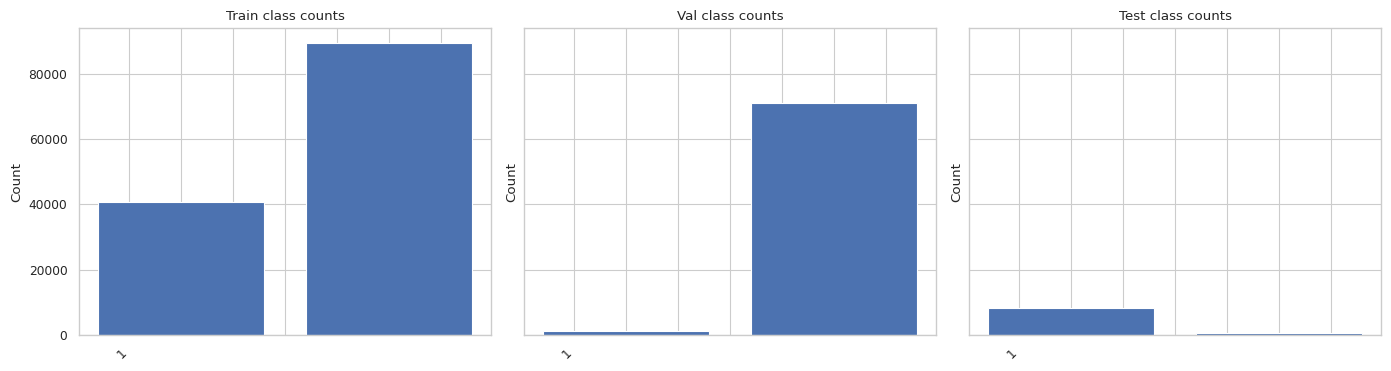

No missing values detected.


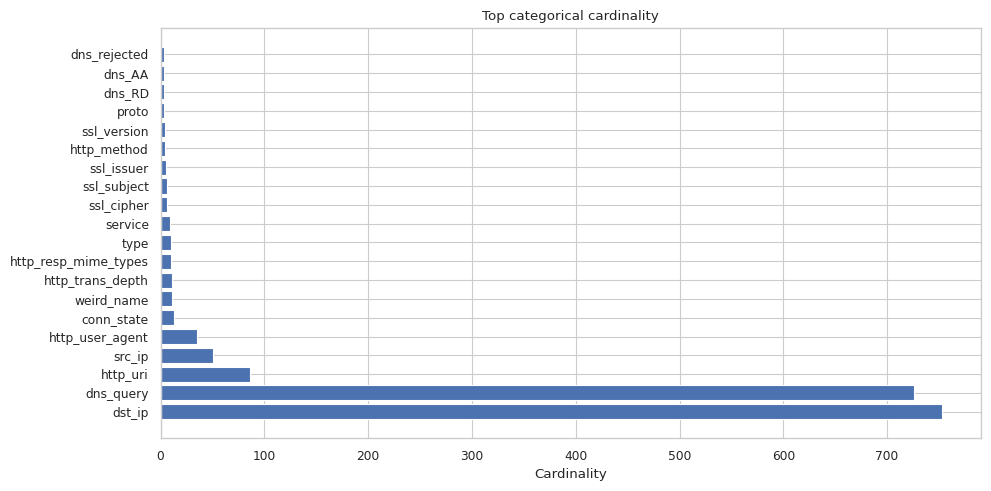

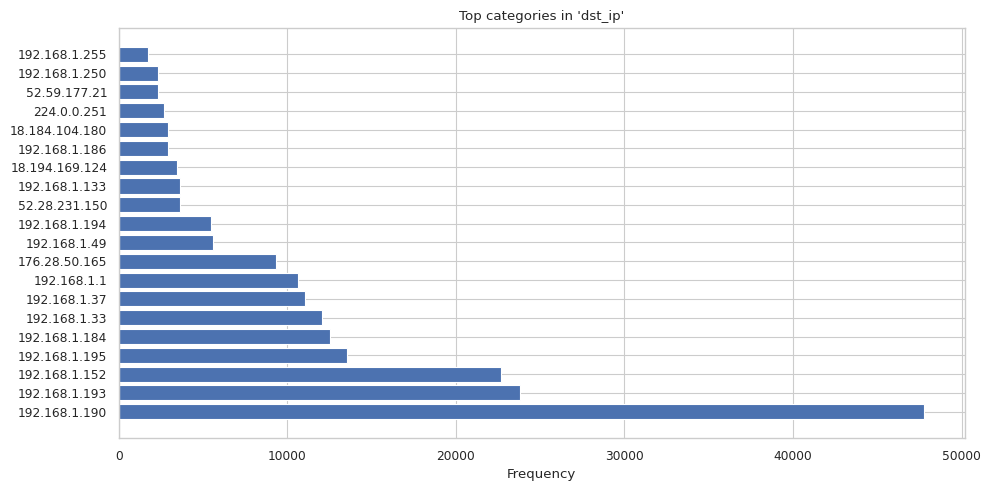

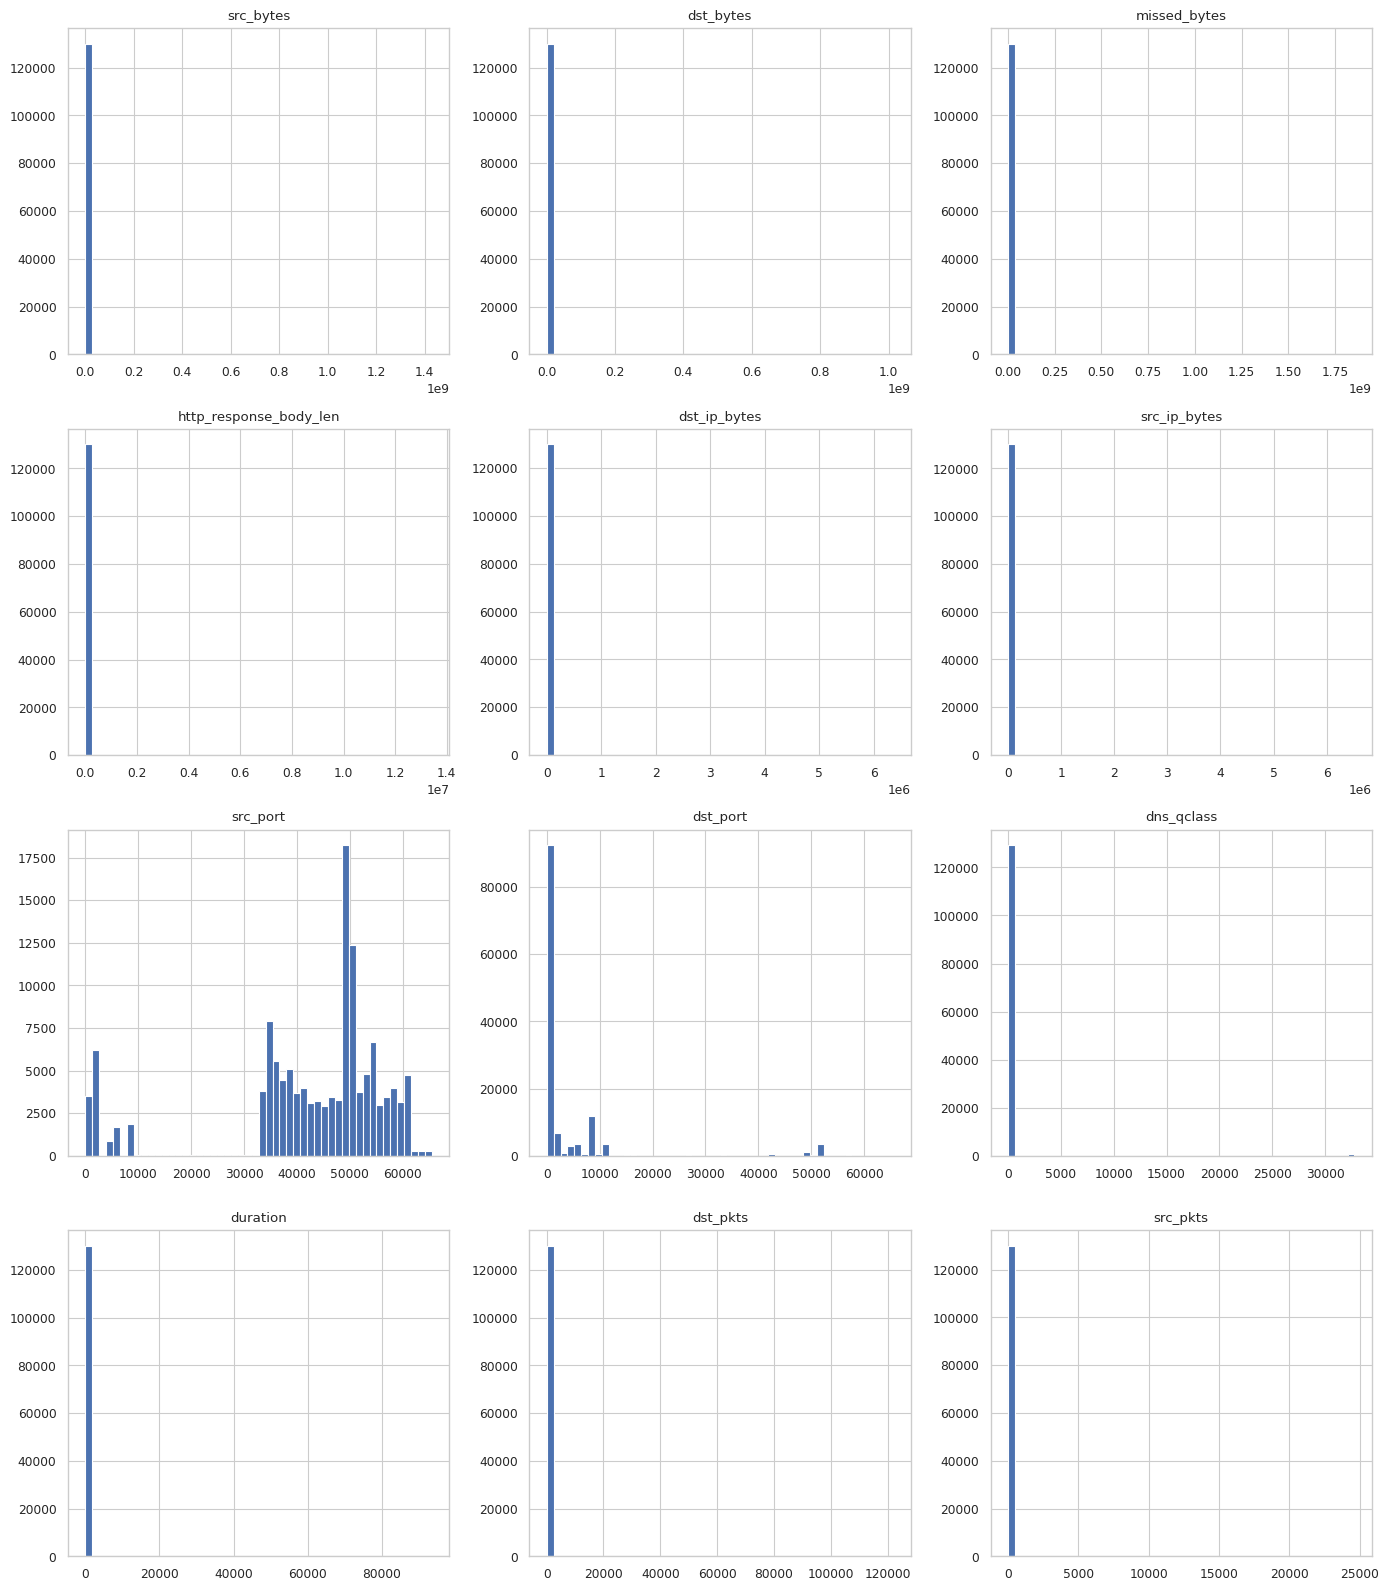

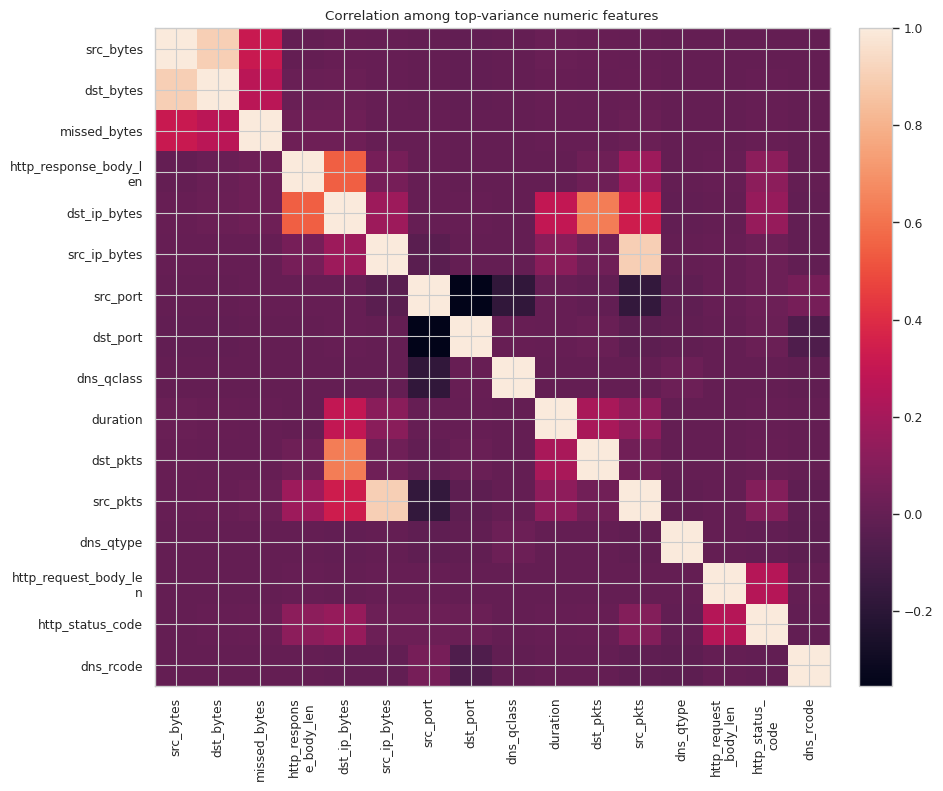

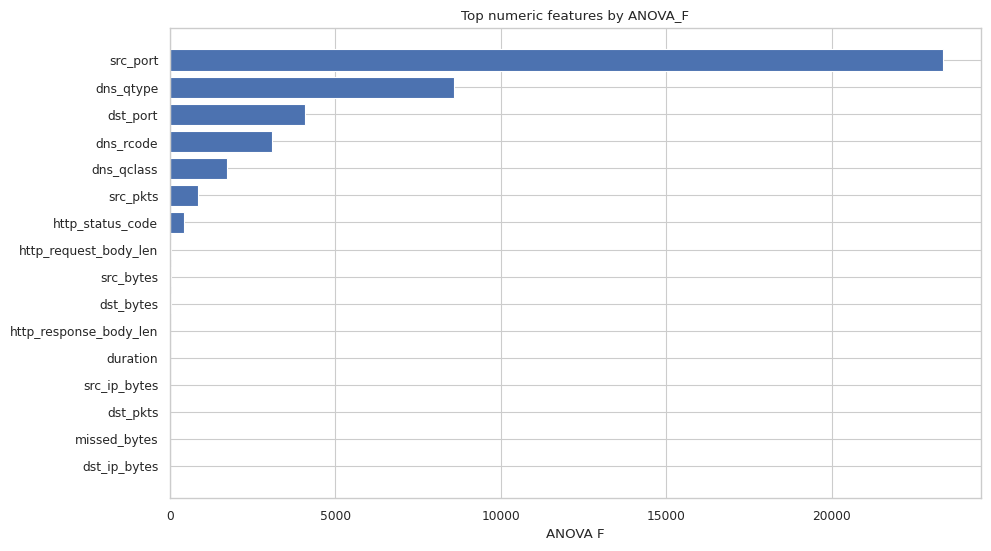

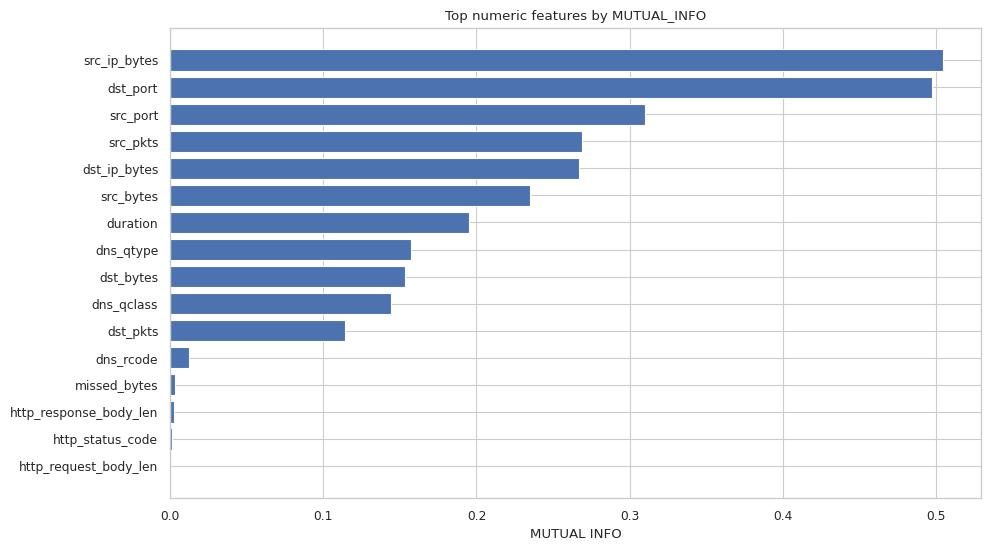

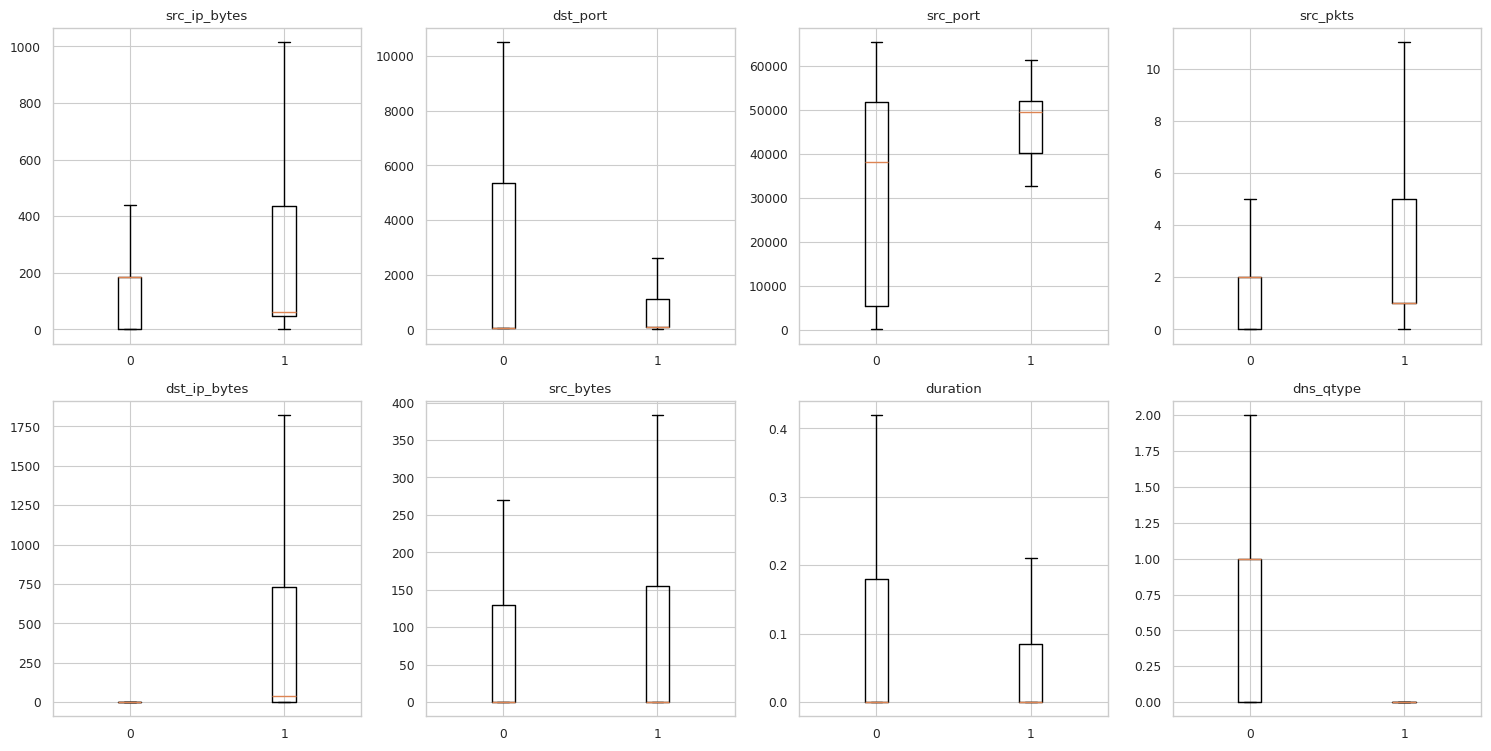

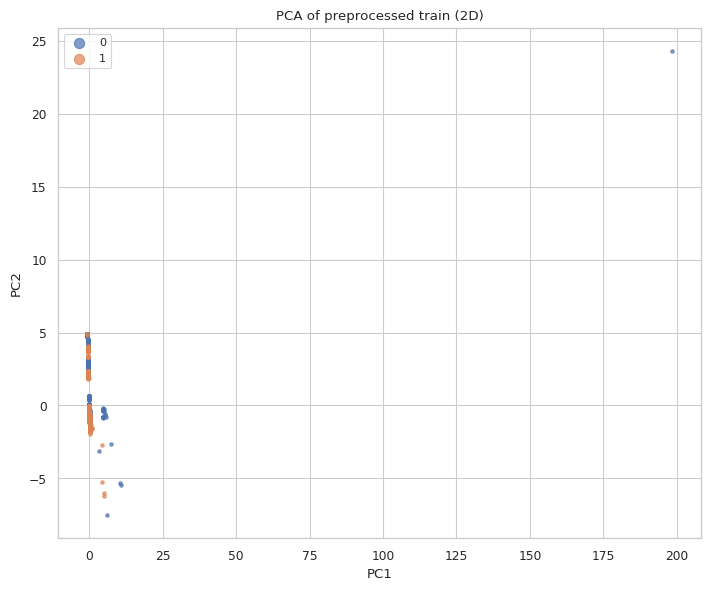

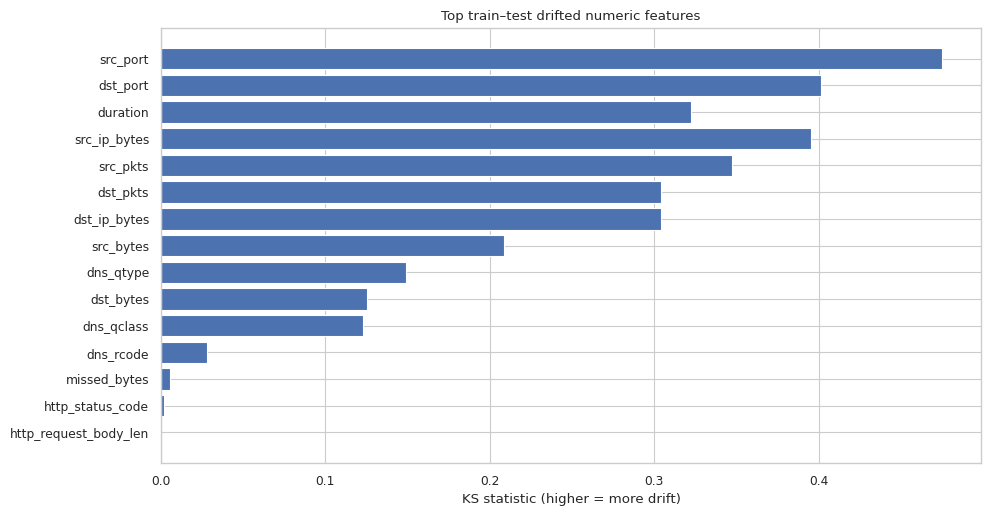

EDA figures saved in: /content/drive/MyDrive/Datasets/TON_IoT_Experiments/ids_experiment_20250913_104557/artifacts

=== Preprocessing workflow summary ===
step_name    transformer  n_inputs  n_outputs                                                                    input_columns                                                                           params
      num StandardScaler        16         16 src_port, dst_port, duration, src_bytes, dst_bytes, missed_bytes, src_pkts, s...                              {"copy": true, "with_mean": true, "with_std": true}
      cat  OneHotEncoder        27       1162 src_ip, dst_ip, proto, service, conn_state, dns_query, dns_AA, dns_RD, dns_RA... {"categories": "auto", "drop": null, "dtype": "<class 'numpy.float64'>", "fea...

Total features: input=43 -> output=1178

Feature map saved with 1178 rows.


In [ ]:
# =========================
# 2) Data Preparation
# =========================
import os, math, warnings, json, textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    sns.set_theme(context="paper", style="whitegrid")
except Exception:
    sns = None

from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.decomposition import PCA
from scipy.stats import ks_2samp
import joblib

warnings.filterwarnings("ignore")

assert os.path.exists(DATA_PATH), f"Dataset not found at {DATA_PATH}. Please adjust DATA_PATH above."
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# ---------- Load and basic schema ----------
df = pd.read_csv(DATA_PATH)
print('Data shape:', df.shape)
print('Columns (head):', list(df.columns)[:20])

# Identify label column
candidate_labels = [c for c in df.columns if c.lower() in ['label', 'class', 'attack', 'target']]
label_col = candidate_labels[0] if candidate_labels else df.columns[-1]

y_raw = df[label_col].astype('category')
y = y_raw.cat.codes.values
classes = list(y_raw.cat.categories)
num_classes = len(classes)

X_df = df.drop(columns=[label_col])
num_cols = X_df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_df.select_dtypes(exclude=[np.number]).columns.tolist()
print(f'Label column: {label_col} | Classes: {classes}')
print(f'Numeric={len(num_cols)}, Categorical={len(cat_cols)}')

# ---------- Source-aware split (devices/subnets/sites), with fallback ----------
def find_group_column(frame: pd.DataFrame) -> str | None:
    # Common IoT/flow "source" fields
    candidates = [
        'device_id','device','src_ip','source_ip','srcaddr','orig_h',
        'subnet_id','subnet','site','host','sensor','gateway'
    ]
    # Also try case-insensitive search for substrings
    cols = list(frame.columns)
    for c in candidates:
        for col in cols:
            if col.lower() == c:
                return col
    for col in cols:
        lc = col.lower()
        if any(k in lc for k in ['device', 'src', 'source', 'subnet', 'site', 'sensor', 'gateway', 'host']):
            # avoid selecting the label or timestamps as group
            if col != label_col and frame[col].nunique(dropna=False) > 1:
                return col
    return None

group_col = find_group_column(df)
print(f"Group column for source-aware split: {group_col if group_col else 'None (fallback to stratified random)'}")

if group_col is not None:
    groups_all = df[group_col].astype(str).values

    # helper: split groups to obtain disjoint Train / Val / Test
    def split_by_groups(frame: pd.DataFrame, groups: np.ndarray, seed: int, test_size=0.20, val_size=0.15):
        # First: Train+Val vs Test by groups
        gss1 = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
        idx_trv, idx_te = next(gss1.split(frame, groups=groups))
        df_trv, df_te = frame.iloc[idx_trv], frame.iloc[idx_te]
        y_trv = y[idx_trv]
        groups_trv = groups[idx_trv]

        # Second: Train vs Val by groups within Train+Val
        # target val fraction relative to TRV
        val_rel = val_size / (1.0 - test_size)
        gss2 = GroupShuffleSplit(n_splits=1, test_size=val_rel, random_state=seed)
        sub_idx_tr, sub_idx_va = next(gss2.split(df_trv, groups=groups_trv))
        df_tr, df_va = df_trv.iloc[sub_idx_tr], df_trv.iloc[sub_idx_va]

        # collect y as codes again for each split
        y_tr = df_tr[label_col].astype('category').cat.codes.values
        y_va = df_va[label_col].astype('category').cat.codes.values
        y_te = df_te[label_col].astype('category').cat.codes.values

        return (df_tr, y_tr), (df_va, y_va), (df_te, y_te), (df_trv, y_trv), (idx_trv, idx_te, sub_idx_tr, sub_idx_va)

    (df_train, y_train), (df_val, y_val), (df_test, y_test), _, index_tuple = split_by_groups(df, groups_all, seed=SEED)

    # save group membership for transparency
    pd.DataFrame({
        'index': np.arange(len(df)),
        'group': groups_all,
        'split': (pd.Series(np.full(len(df), 'test'))
                  .mask(df.index.isin(df_train.index), 'train')
                  .mask(df.index.isin(df_val.index), 'val'))
    }).to_csv(ARTIFACTS_DIR / "02_data_group_membership.csv", index=False)

    print(f"Source-aware splits: train={len(df_train)}, val={len(df_val)}, test={len(df_test)}")
else:
    # Fallback: stratified random split (original behavior)
    df_train, df_temp, y_train, y_temp = train_test_split(
        X_df.join(pd.Series(y, name='_y_')), y, test_size=0.30, stratify=y, random_state=SEED
    )
    df_val, df_test, y_val, y_test = train_test_split(
        df_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=SEED
    )
    # unwrap features only
    y_train = df_train.pop('_y_').values
    y_val   = df_val.pop('_y_').values
    y_test  = df_test.pop('_y_').values
    print(f"Stratified random splits: train={len(df_train)}, val={len(df_val)}, test={len(df_test)}")

# Align X_df with chosen splits
if group_col is not None:
    X_train, X_val, X_test = df_train.drop(columns=[label_col]), df_val.drop(columns=[label_col]), df_test.drop(columns=[label_col])
else:
    X_train, X_val, X_test = df_train, df_val, df_test

# ---------- Preprocess ----------
numeric_transformer = StandardScaler(with_mean=True, with_std=True)
# OneHotEncoder API differs across sklearn versions; 'sparse_output' is valid for >=1.2
try:
    categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols),
    ],
    remainder='drop',
)

X_train_np = preprocess.fit_transform(X_train)
X_val_np   = preprocess.transform(X_val)
X_test_np  = preprocess.transform(X_test)

joblib.dump(preprocess, ARTIFACTS_DIR / 'preprocess.joblib')
joblib.dump(classes, ARTIFACTS_DIR / 'classes.joblib')
joblib.dump(num_cols, ARTIFACTS_DIR / 'num_cols.joblib')
joblib.dump(cat_cols, ARTIFACTS_DIR / 'cat_cols.joblib')

feat_names = []
feat_names.extend(num_cols)
if len(cat_cols) > 0:
    enc = preprocess.named_transformers_['cat']
    try:
        cat_feat_names = enc.get_feature_names_out(cat_cols).tolist()
    except Exception:
        # fallback for older sklearn
        cat_feat_names = [f"cat_{i}" for i in range(X_train_np.shape[1] - len(num_cols))]
    feat_names.extend(cat_feat_names)
joblib.dump(feat_names, ARTIFACTS_DIR / 'feature_names.joblib')

print('Transformed shapes:', X_train_np.shape, X_val_np.shape, X_test_np.shape)
try:
    log_event('data_split', {
        'train': len(y_train), 'val': len(y_val), 'test': len(y_test),
        'n_features': int(X_train_np.shape[1]),
        'source_aware': bool(group_col is not None),
        'group_col': None if group_col is None else str(group_col)
    })
except Exception:
    pass

# =========================
# Enhanced EDA & Research-Grade Plots
# =========================
PREF = "02_data_"

def _save(fig, name, dpi=300):
    path = ARTIFACTS_DIR / f"{PREF}{name}.png"
    fig.tight_layout()
    fig.savefig(path, dpi=dpi, bbox_inches="tight")
    plt.show()
    plt.close(fig)

def _wrap(s, width=32):
    return "\n".join(textwrap.wrap(s, width=width))

# 1) Class imbalance: overall and per split
def plot_class_distribution():
    fig, ax = plt.subplots(1, 3, figsize=(14, 3.8), sharey=True)
    for a, split_y, title in zip(ax, [y_train, y_val, y_test], ["Train", "Val", "Test"]):
        vals, cnts = np.unique(split_y, return_counts=True)
        labels = [classes[v] if v < len(classes) else str(v) for v in vals]
        a.bar(labels, cnts)
        a.set_title(f"{title} class counts")
        a.set_xticklabels(labels, rotation=45, ha='right')
        a.set_ylabel("Count")
    _save(fig, "class_distribution")

plot_class_distribution()

# 2) Missingness profile
def plot_missingness():
    miss = df.isna().mean().sort_values(ascending=False)
    if miss.sum() == 0:
        print("No missing values detected.")
        return
    top = miss[miss > 0].head(40)
    fig, ax = plt.subplots(figsize=(10, max(3, 0.25*len(top))))
    ax.barh(top.index, top.values)
    ax.set_xlabel("Missing ratio")
    ax.set_title("Top missing features")
    _save(fig, "missingness_top")

plot_missingness()

# 3) Categorical cardinality and top categories
def plot_categorical_profiles():
    if len(cat_cols) == 0:
        print("No categorical columns.")
        return
    # cardinality
    card = pd.Series({c: X_df[c].nunique(dropna=False) for c in cat_cols}).sort_values(ascending=False)
    top_card = card.head(20)
    fig, ax = plt.subplots(figsize=(10, max(3, 0.25*len(top_card))))
    ax.barh(top_card.index, top_card.values)
    ax.set_xlabel("Cardinality")
    ax.set_title("Top categorical cardinality")
    _save(fig, "categorical_cardinality")

    # top tokens in the most frequent categorical column
    top_col = top_card.index[0]
    freq = X_df[top_col].value_counts(dropna=False).head(20)
    fig, ax = plt.subplots(figsize=(10, max(3, 0.25*len(freq))))
    ax.barh(freq.index.astype(str), freq.values)
    ax.set_xlabel("Frequency")
    ax.set_title(f"Top categories in '{_wrap(top_col)}'")
    _save(fig, "categorical_top_tokens")

plot_categorical_profiles()

# 4) Numeric variance ranking + histograms
def plot_numeric_histograms():
    if len(num_cols) == 0:
        print("No numeric columns.")
        return
    var = X_train[num_cols].var().sort_values(ascending=False)
    var.to_csv(ARTIFACTS_DIR / f"{PREF}numeric_variance.csv", index=False)
    top_feats = var.index[:12].tolist()
    n = len(top_feats)
    cols = 3
    rows = math.ceil(n/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(14, 4*rows))
    axes = np.array(axes).reshape(rows, cols)
    for i, f in enumerate(top_feats):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        ax.hist(X_train[f].values, bins=50)
        ax.set_title(_wrap(f))
    # clean empty subplots
    for j in range(n, rows*cols):
        r, c = divmod(j, cols); fig.delaxes(axes[r, c])
    _save(fig, "numeric_hist_topvar")

plot_numeric_histograms()

# 5) Correlation heatmap on top-variance numeric features
def plot_correlation_heatmap():
    if len(num_cols) == 0:
        return
    top = X_train[num_cols].var().sort_values(ascending=False).index[:20]
    corr = X_train[top].corr()
    fig, ax = plt.subplots(figsize=(9.5, 8))
    im = ax.imshow(corr.values, aspect='auto', interpolation='nearest')
    ax.set_xticks(range(len(top))); ax.set_yticks(range(len(top)))
    ax.set_xticklabels([_wrap(t, 12) for t in top], rotation=90)
    ax.set_yticklabels([_wrap(t, 20) for t in top])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title("Correlation among top-variance numeric features")
    _save(fig, "correlation_topvar")

plot_correlation_heatmap()

# 6) Supervised ranking: ANOVA-F and Mutual Information for numeric
def plot_supervised_ranking():
    if len(num_cols) == 0:
        print("No numeric columns for supervised ranking.")
        return
    Xn = X_train[num_cols].values
    f_vals, _ = f_classif(Xn, y_train)
    mi_vals = mutual_info_classif(Xn, y_train, discrete_features=False, random_state=SEED)
    df_rank = pd.DataFrame({
        'feature': num_cols,
        'anova_f': f_vals,
        'mutual_info': mi_vals
    })
    df_rank.sort_values('anova_f', ascending=False).to_csv(ARTIFACTS_DIR / f"{PREF}anova_mutualinfo_numeric.csv", index=False)

    for score_name in ['anova_f', 'mutual_info']:
        top = df_rank.sort_values(score_name, ascending=False).head(20)
        fig, ax = plt.subplots(figsize=(10, max(3, 0.35*len(top))))
        ax.barh(top['feature'], top[score_name])
        ax.invert_yaxis()
        ax.set_xlabel(score_name.replace('_',' ').upper())
        ax.set_title(f"Top numeric features by {score_name.upper()}")
        _save(fig, f"top20_numeric_{score_name}")

plot_supervised_ranking()

# 7) Boxplots by class for top MI numeric features
def plot_boxplots_top_mi():
    if len(num_cols) == 0:
        return
    Xn = X_train[num_cols].values
    mi_vals = mutual_info_classif(Xn, y_train, discrete_features=False, random_state=SEED)
    order = np.argsort(mi_vals)[::-1][:8]
    top_feats = [num_cols[i] for i in order]
    # to keep memory low, sample
    sample_idx = np.random.RandomState(SEED).choice(len(X_train), size=min(5000, len(X_train)), replace=False)
    dsmall = X_train.iloc[sample_idx][top_feats].copy()
    dsmall[label_col] = pd.Categorical.from_codes(y_train[sample_idx], categories=classes)
    n = len(top_feats); cols = 4; rows = math.ceil(n/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3.8*rows))
    axes = np.array(axes).reshape(rows, cols)
    for i, f in enumerate(top_feats):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        # simple violin-like distribution via boxplot overlays
        data = [dsmall[dsmall[label_col]==cl][f].values for cl in classes]
        ax.boxplot(data, showfliers=False)
        ax.set_xticklabels([_wrap(str(cl), 12) for cl in classes], rotation=0)
        ax.set_title(_wrap(f))
    for j in range(n, rows*cols):
        r, c = divmod(j, cols); fig.delaxes(axes[r, c])
    _save(fig, "boxplots_top_mi_by_class")

plot_boxplots_top_mi()

# 8) PCA 2D on preprocessed space
def plot_pca_scatter():
    # subsample for speed
    nmax = 15000
    rs = np.random.RandomState(SEED)
    idx = rs.choice(len(y_train), size=min(nmax, len(y_train)), replace=False)
    Xs = X_train_np[idx]
    ys = y_train[idx]
    pca = PCA(n_components=2, random_state=SEED)
    Z = pca.fit_transform(Xs)
    fig, ax = plt.subplots(figsize=(7.2, 6))
    for c in np.unique(ys):
        ax.scatter(Z[ys==c,0], Z[ys==c,1], s=6, alpha=0.7, label=str(classes[c]) if c < len(classes) else str(c))
    ax.set_title("PCA of preprocessed train (2D)")
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
    ax.legend(markerscale=3, frameon=True, fontsize=8)
    _save(fig, "pca2d_train")

plot_pca_scatter()

# 9) Train–test drift on numeric features via KS test
def plot_train_test_drift():
    if len(num_cols) == 0:
        return
    res = []
    for f in num_cols:
        try:
            stat, p = ks_2samp(X_train[f].astype(float), X_test[f].astype(float))
            res.append((f, stat, p))
        except Exception:
            continue
    drift = pd.DataFrame(res, columns=['feature','ks_stat','p_value']).sort_values('p_value')
    drift.to_csv(ARTIFACTS_DIR / f"{PREF}train_test_ks_drift.csv", index=False)
    top = drift.head(15)
    fig, ax = plt.subplots(figsize=(10, max(3, 0.35*len(top))))
    ax.barh(top['feature'], top['ks_stat'])
    ax.invert_yaxis()
    ax.set_xlabel("KS statistic (higher = more drift)")
    ax.set_title("Top train–test drifted numeric features")
    _save(fig, "train_test_drift_top")

plot_train_test_drift()

# 10) Split-size summary and basic schema table (saved as CSV)
pd.DataFrame({
    'split': ['train','val','test'],
    'n_samples': [len(y_train), len(y_val), len(y_test)]
}).to_csv(ARTIFACTS_DIR / f"{PREF}split_sizes.csv", index=False)

schema = pd.DataFrame({
    'feature': X_df.columns,
    'dtype': X_df.dtypes.astype(str),
    'is_numeric': [c in num_cols for c in X_df.columns],
    'n_unique': [X_df[c].nunique(dropna=False) for c in X_df.columns]
})
schema.to_csv(ARTIFACTS_DIR / f"{PREF}schema_overview.csv", index=False)

# If source-aware, save label distribution per split for auditability
if group_col is not None:
    def _dist(y_arr):
        vals, cnts = np.unique(y_arr, return_counts=True)
        return pd.DataFrame({'class_id': vals, 'class': [classes[v] for v in vals], 'count': cnts})
    _dist(y_train).to_csv(ARTIFACTS_DIR / f"{PREF}train_label_dist.csv", index=False)
    _dist(y_val).to_csv(ARTIFACTS_DIR / f"{PREF}val_label_dist.csv", index=False)
    _dist(y_test).to_csv(ARTIFACTS_DIR / f"{PREF}test_label_dist.csv", index=False)

print("EDA figures saved in:", ARTIFACTS_DIR)

# ---------- Preprocessing workflow: printable summary + CSV artifacts ----------

def _safe_params(est):
    try:
        # keep only JSON-serializable shallow params
        p = est.get_params(deep=False)
        for k, v in list(p.items()):
            try:
                json.dumps(v)
            except Exception:
                p[k] = str(v)
        return json.dumps(p)
    except Exception:
        return "{}"

workflow_rows = []
try:
    # traverse fitted transformers
    for name, trans, cols in getattr(preprocess, "transformers_", []):
        if name == "remainder":
            continue

        # resolve column names robustly
        if isinstance(cols, slice):
            in_cols = X_df.columns[cols].tolist()
        elif isinstance(cols, (list, tuple, np.ndarray, pd.Index)):
            in_cols = list(cols)
        else:
            in_cols = [str(cols)]

        # estimate output dimensionality
        out_dim = None
        try:
            if hasattr(trans, "get_feature_names_out"):
                try:
                    out_dim = len(trans.get_feature_names_out(in_cols))
                except Exception:
                    out_dim = len(in_cols)
            else:
                out_dim = len(in_cols)
        except Exception:
            out_dim = len(in_cols)

        workflow_rows.append({
            "step_name": name,
            "transformer": type(trans).__name__,
            "n_inputs": len(in_cols),
            "n_outputs": int(out_dim),
            "input_columns": ", ".join(map(str, in_cols)) if len(in_cols) <= 40 else f"{len(in_cols)} columns",
            "params": _safe_params(trans),
        })

    workflow_df = pd.DataFrame(workflow_rows, columns=[
        "step_name","transformer","n_inputs","n_outputs","input_columns","params"
    ])

    # Save CSV
    workflow_csv_path = ARTIFACTS_DIR / f"{PREF}preprocess_workflow.csv"
    workflow_df.to_csv(workflow_csv_path, index=False)

    # Pretty print to stdout
    print("\n=== Preprocessing workflow summary ===")
    if not workflow_df.empty:
        print(workflow_df.to_string(index=False, max_colwidth=80))
    else:
        print("No explicit transformers found.")

    # Global in/out dimensionality
    try:
        print(f"\nTotal features: input={X_df.shape[1]} -> output={X_train_np.shape[1]}")
    except Exception:
        pass

    # Optional: feature map (original -> transformed)
    try:
        feat_map_rows = []
        # numeric: identity mapping
        for f in num_cols:
            feat_map_rows.append({"source_feature": f, "output_feature": f, "transformer": "StandardScaler"})

        # categorical: expanded mapping if encoder present
        if len(cat_cols) > 0 and "cat" in preprocess.named_transformers_:
            enc = preprocess.named_transformers_["cat"]
            try:
                ohe_names = enc.get_feature_names_out(cat_cols).tolist()
            except Exception:
                ohe_names = []
            for on in ohe_names:
                src = on.split("_", 1)[0] if "_" in on else on
                feat_map_rows.append({"source_feature": src, "output_feature": on, "transformer": "OneHotEncoder"})

        if feat_map_rows:
            feat_map_df = pd.DataFrame(feat_map_rows, columns=["source_feature","output_feature","transformer"])
            feat_map_df.to_csv(ARTIFACTS_DIR / f"{PREF}feature_map.csv", index=False)
            print(f"\nFeature map saved with {len(feat_map_rows)} rows.")
        else:
            print("\nFeature map not generated (no features or encoder output unavailable).")

    except Exception as e:
        print(f"\n[Warn] Feature map generation skipped: {e}")

except Exception as e:
    print(f"[Warn] Could not summarize preprocessing workflow: {e}")


## Teacher training & evaluation

In [ ]:
# =========================
# 3) Teacher Model (MLP)
# =========================
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, matthews_corrcoef,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import joblib

# Ensure artifacts dir exists
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

def get_loader(X, y, batch_size, shuffle):
    ds = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long))
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle,
                      num_workers=2, pin_memory=torch.cuda.is_available())

class MLPTeacher(nn.Module):
    def __init__(self, in_dim, num_classes, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.head = nn.Linear(128, num_classes)
    def forward(self, x):
        return self.head(self.net(x))

def compute_class_weights(y, num_classes):
    """Return a weight tensor of length num_classes; unseen classes get weight 1.0."""
    classes_present = np.unique(y)
    w_present = compute_class_weight(class_weight='balanced', classes=classes_present, y=y)
    w_full = np.ones(num_classes, dtype=np.float32)
    w_full[classes_present] = w_present.astype(np.float32)
    return torch.tensor(w_full, dtype=torch.float32, device=DEVICE)

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None, reduction='mean'):
        super().__init__()
        self.gamma, self.weight, self.reduction = gamma, weight, reduction
    def forward(self, logits, target):
        ce = F.cross_entropy(logits, target, weight=self.weight, reduction='none')
        pt = torch.exp(-ce)
        loss = ((1-pt)**self.gamma) * ce
        return loss.mean() if self.reduction=='mean' else loss.sum()

def evaluate(model, loader, loss_fn=None):
    model.eval()
    logits_all, y_all = [], []
    running_loss, nobs = 0.0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE); yb = yb.to(DEVICE)
            logits = model(xb)
            if loss_fn is not None:
                loss_b = loss_fn(logits, yb)
                bs = xb.size(0)
                running_loss += float(loss_b.item()) * bs
                nobs += bs
            logits_all.append(logits.cpu()); y_all.append(yb.cpu())
    logits = torch.cat(logits_all); y_true = torch.cat(y_all).numpy()
    y_pred = logits.argmax(1).numpy()
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    try:
        y_prob = torch.softmax(logits, dim=1).numpy()
        roc_auc = roc_auc_score(y_true, y_prob, average='macro', multi_class='ovr')
    except Exception:
        roc_auc = float('nan')
    mcc = matthews_corrcoef(y_true, y_pred)
    out = {'acc': acc, 'macro_f1': macro_f1, 'roc_auc': roc_auc, 'mcc': mcc,
           'y_true': y_true, 'y_pred': y_pred}
    if loss_fn is not None and nobs > 0:
        out['loss'] = running_loss / nobs
    return out

def get_current_lr(optim):
    for pg in optim.param_groups:
        return pg.get('lr', None)
    return None

# Data loaders
train_loader = get_loader(X_train_np, y_train, HP.batch_size, True)
val_loader   = get_loader(X_val_np,   y_val,   HP.batch_size, False)
test_loader  = get_loader(X_test_np,  y_test,  HP.batch_size, False)

# Model, optimizer, scheduler, criterion
teacher = MLPTeacher(in_dim=X_train_np.shape[1], num_classes=num_classes, dropout=HP.dropout).to(DEVICE)
optimizer = torch.optim.AdamW(teacher.parameters(), lr=HP.lr, weight_decay=HP.weight_decay)
if HP.scheduler == 'cosine':
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=HP.epochs)
elif HP.scheduler == 'step':
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=HP.step_size, gamma=HP.gamma)
else:
    scheduler = None

cls_w = compute_class_weights(y_train, num_classes=num_classes)
criterion = FocalLoss(weight=cls_w) if getattr(HP, 'use_focal', False) else nn.CrossEntropyLoss(weight=cls_w)

# Training loop with history
best_val_f1, wait = -1.0, 0
best_path = ARTIFACTS_DIR / 'teacher.pt'
history = []  # list of dicts

for epoch in range(HP.epochs):
    teacher.train()
    running_loss, nobs = 0.0, 0
    for xb, yb in train_loader:
        xb = xb.to(DEVICE); yb = yb.to(DEVICE)
        optimizer.zero_grad()
        logits = teacher(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        bs = xb.size(0)
        running_loss += float(loss.item()) * bs
        nobs += bs

    if scheduler is not None:
        scheduler.step()

    train_loss = running_loss / max(1, nobs)
    val_m = evaluate(teacher, val_loader, loss_fn=criterion)

    # Log minimal scalar info for console/debug
    log_event('teacher_epoch', {
        'epoch': epoch+1,
        'train_loss': train_loss,
        'val_loss': val_m.get('loss', np.nan),
        'val_acc': val_m['acc'],
        'val_macro_f1': val_m['macro_f1'],
        'val_roc_auc': val_m['roc_auc'],
        'val_mcc': val_m['mcc'],
        'lr': get_current_lr(optimizer),
    })

    # Append to history for plotting
    history.append({
        'epoch': epoch+1,
        'train_loss': train_loss,
        'val_loss': val_m.get('loss', np.nan),
        'val_acc': val_m['acc'],
        'val_macro_f1': val_m['macro_f1'],
        'val_roc_auc': val_m['roc_auc'],
        'val_mcc': val_m['mcc'],
        'lr': get_current_lr(optimizer),
    })

    # Early stopping on macro-F1
    if val_m['macro_f1'] > best_val_f1 + 1e-4:
        best_val_f1, wait = val_m['macro_f1'], 0
        torch.save(teacher.state_dict(), best_path)
    else:
        wait += 1
        if wait >= HP.patience:
            break

# Load best and final evaluation
teacher.load_state_dict(torch.load(best_path, map_location=DEVICE))
val_metrics  = evaluate(teacher, val_loader, loss_fn=criterion)
test_metrics = evaluate(teacher, test_loader, loss_fn=criterion)

# Save classification reports
with open(ARTIFACTS_DIR / 'teacher_val_report.txt','w') as f:
    f.write(classification_report(val_metrics['y_true'], val_metrics['y_pred'],
        target_names=[str(c) for c in classes], digits=4, zero_division=0))
with open(ARTIFACTS_DIR / 'teacher_test_report.txt','w') as f:
    f.write(classification_report(test_metrics['y_true'], test_metrics['y_pred'],
        target_names=[str(c) for c in classes], digits=4, zero_division=0))

# Confusion matrix on test set
cm = confusion_matrix(test_metrics['y_true'], test_metrics['y_pred'])
plt.figure()
disp = ConfusionMatrixDisplay(cm, display_labels=[str(c) for c in classes])
disp.plot(xticks_rotation=45, values_format='d', cmap=None, colorbar=False)
plt.tight_layout()
plt.savefig(ARTIFACTS_DIR / 'teacher_cm_test.png', dpi=150)
plt.close()

# ----- Convergence history: save CSV and plots -----
hist_df = pd.DataFrame(history)
hist_csv_path = ARTIFACTS_DIR / 'teacher_training_history.csv'
hist_df.to_csv(hist_csv_path, index=False)

# 1) Loss curves
plt.figure(figsize=(6.4, 4.8))
plt.plot(hist_df['epoch'], hist_df['train_loss'], label='Train loss')
if 'val_loss' in hist_df and np.isfinite(hist_df['val_loss']).any():
    plt.plot(hist_df['epoch'], hist_df['val_loss'], label='Val loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Teacher convergence: loss'); plt.legend()
plt.grid(True, linewidth=0.3, alpha=0.6)
plt.tight_layout()
plt.savefig(ARTIFACTS_DIR / 'teacher_loss_curve.png', dpi=150)
plt.close()

# 2) Validation metrics curves
plt.figure(figsize=(6.8, 5.0))
plt.plot(hist_df['epoch'], hist_df['val_macro_f1'], label='Val macro-F1')
plt.plot(hist_df['epoch'], hist_df['val_acc'], label='Val accuracy')
if np.isfinite(hist_df['val_roc_auc']).any():
    plt.plot(hist_df['epoch'], hist_df['val_roc_auc'], label='Val ROC-AUC')
plt.plot(hist_df['epoch'], hist_df['val_mcc'], label='Val MCC')
plt.xlabel('Epoch'); plt.ylabel('Score'); plt.title('Teacher convergence: validation metrics'); plt.legend()
plt.ylim(0.0, 1.0)
plt.grid(True, linewidth=0.3, alpha=0.6)
plt.tight_layout()
plt.savefig(ARTIFACTS_DIR / 'teacher_val_metrics_curve.png', dpi=150)
plt.close()

# 3) Learning rate schedule
lr_vals = hist_df['lr'].values
if np.any(pd.notnull(lr_vals)):
    plt.figure(figsize=(6.4, 4.2))
    plt.plot(hist_df['epoch'], lr_vals, label='Learning rate')
    plt.xlabel('Epoch'); plt.ylabel('LR'); plt.title('Teacher learning rate schedule'); plt.legend()
    plt.grid(True, linewidth=0.3, alpha=0.6)
    plt.tight_layout()
    plt.savefig(ARTIFACTS_DIR / 'teacher_lr_curve.png', dpi=150)
    plt.close()

# Persist scalar metrics for reproducibility
joblib.dump({'val': val_metrics, 'test': test_metrics}, ARTIFACTS_DIR / 'teacher_metrics.joblib')

print('Teacher test:', {k: v for k, v in test_metrics.items() if k not in ['y_true', 'y_pred']})
print(f'Convergence history saved to: {hist_csv_path}')


[LOG] teacher_epoch: ['epoch', 'train_loss', 'val_loss', 'val_acc', 'val_macro_f1', 'val_roc_auc', 'val_mcc', 'lr']
[LOG] teacher_epoch: ['epoch', 'train_loss', 'val_loss', 'val_acc', 'val_macro_f1', 'val_roc_auc', 'val_mcc', 'lr']
[LOG] teacher_epoch: ['epoch', 'train_loss', 'val_loss', 'val_acc', 'val_macro_f1', 'val_roc_auc', 'val_mcc', 'lr']
[LOG] teacher_epoch: ['epoch', 'train_loss', 'val_loss', 'val_acc', 'val_macro_f1', 'val_roc_auc', 'val_mcc', 'lr']
[LOG] teacher_epoch: ['epoch', 'train_loss', 'val_loss', 'val_acc', 'val_macro_f1', 'val_roc_auc', 'val_mcc', 'lr']
[LOG] teacher_epoch: ['epoch', 'train_loss', 'val_loss', 'val_acc', 'val_macro_f1', 'val_roc_auc', 'val_mcc', 'lr']
[LOG] teacher_epoch: ['epoch', 'train_loss', 'val_loss', 'val_acc', 'val_macro_f1', 'val_roc_auc', 'val_mcc', 'lr']
[LOG] teacher_epoch: ['epoch', 'train_loss', 'val_loss', 'val_acc', 'val_macro_f1', 'val_roc_auc', 'val_mcc', 'lr']
[LOG] teacher_epoch: ['epoch', 'train_loss', 'val_loss', 'val_acc', 'val

<Figure size 640x480 with 0 Axes>

## SHAP ranking & top-K selection

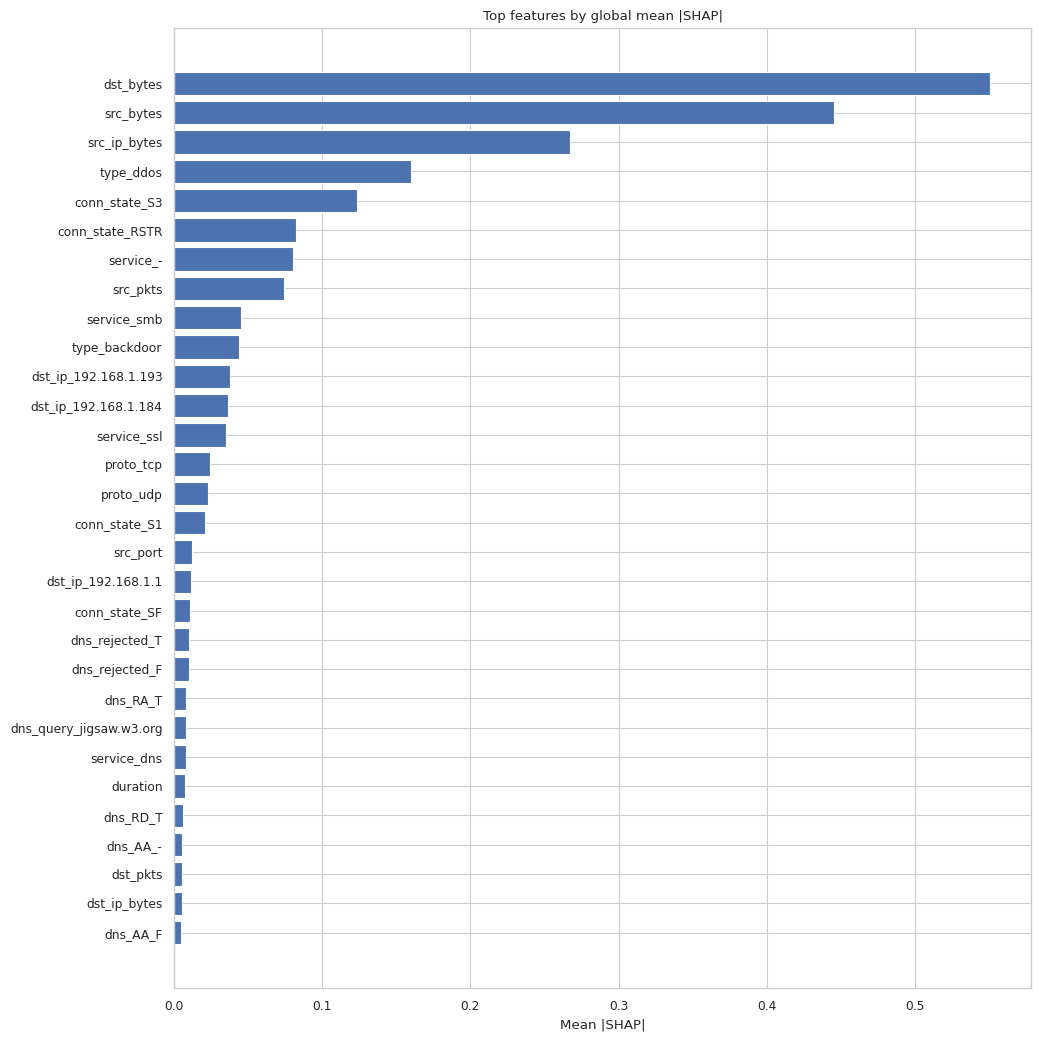

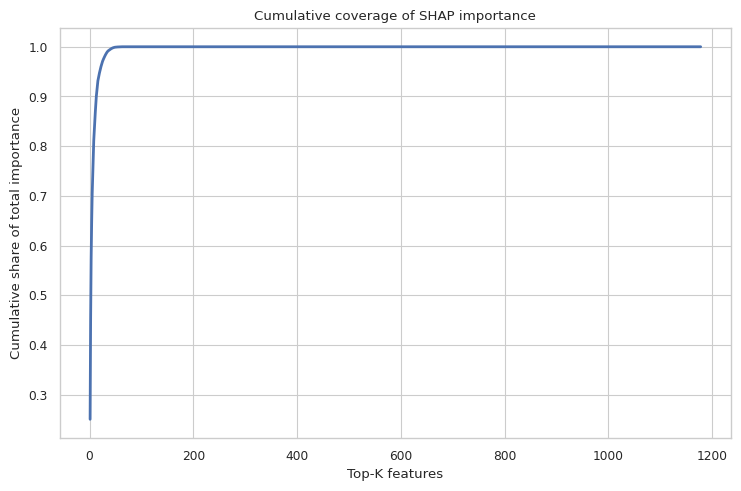

K=128 macro-F1=0.9998
K=192 macro-F1=0.9992
K=256 macro-F1=0.9992
K=320 macro-F1=0.9992
K=384 macro-F1=0.9992


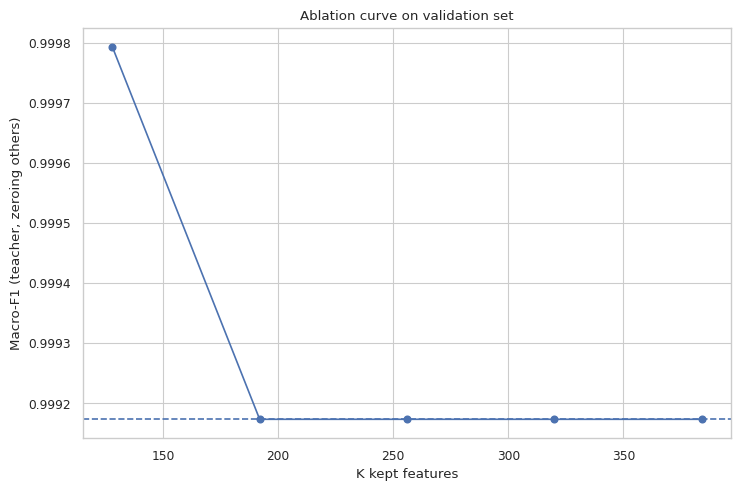

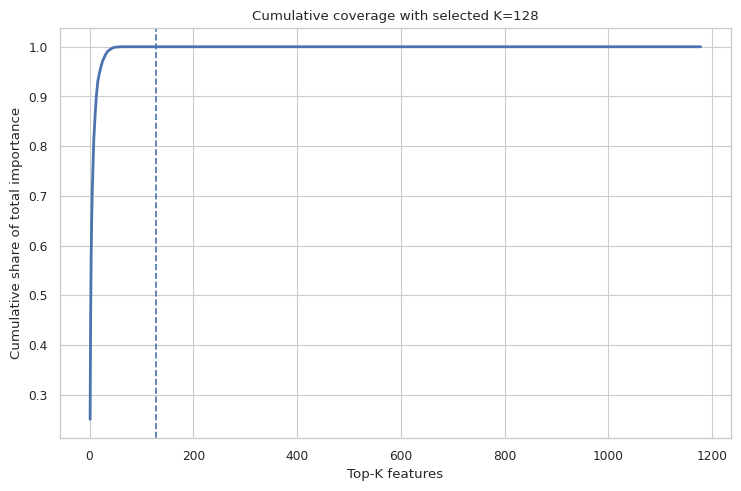

[INFO] Selected K = 128 | Saved to /content/drive/MyDrive/Datasets/TON_IoT_Experiments/ids_experiment_20250913_104557/artifacts/selected_feature_idx.joblib


In [ ]:
# =========================
# 4) Explainability (SHAP) & Pruning
# =========================
import os, warnings, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import shap, torch, joblib
import torch.nn as nn

warnings.filterwarnings("ignore")
os.makedirs(ARTIFACTS_DIR, exist_ok=True)
PREF = "04_shap_"

def _save(fig, name, dpi=300):
    path = ARTIFACTS_DIR / f"{PREF}{name}.png"
    fig.tight_layout()
    fig.savefig(path, dpi=dpi, bbox_inches="tight")
    plt.show()
    plt.close(fig)

def to_numpy(x):
    return x.detach().cpu().numpy() if torch.is_tensor(x) else np.asarray(x)

def reduce_feature_axis(arr: np.ndarray) -> np.ndarray:
    # SHAP returns (n_samples, n_features, ...) — average over non-feature axes → (n_features,)
    if arr.ndim < 2:
        return arr.ravel()
    arr_feat_first = np.moveaxis(arr, 1, 0)                     # (n_features, n_samples, ...)
    return arr_feat_first.mean(axis=tuple(range(1, arr_feat_first.ndim))).ravel()

# -------- 4.1 SHAP (fast settings) --------
# Keep only what is necessary for a robust global ranking
teacher.eval()
sample_size = int(min(512, len(X_val_np)))                      # lean setting
bg_size     = int(min(32, sample_size))                         # lean setting
X_val_sample = X_val_np[:sample_size]
background   = X_val_sample[np.random.choice(sample_size, size=bg_size, replace=False)]

# Use GradientExplainer for speed and stability on MLP-like teachers
explainer_type = "GradientExplainer"
explainer = shap.GradientExplainer(
    teacher, torch.tensor(background, dtype=torch.float32).to(DEVICE)
)
sv_raw = explainer.shap_values(torch.tensor(X_val_sample, dtype=torch.float32).to(DEVICE))

# Harmonize SHAP arrays to a global 1-D importance vector
if isinstance(sv_raw, list):
    sv_list = [np.abs(to_numpy(s)) for s in sv_raw]             # list of (n, d, ...)
    per_class_imp = np.stack([reduce_feature_axis(s) for s in sv_list], axis=0)  # (C, d)
    feature_importances = per_class_imp.mean(axis=0)            # (d,)
else:
    sv = np.abs(to_numpy(sv_raw))                               # (n, d, ...)
    per_class_imp = None
    feature_importances = reduce_feature_axis(sv)               # (d,)

# Rank and persist
rank_idx = np.argsort(-feature_importances).astype(int)
joblib.dump(rank_idx, ARTIFACTS_DIR / 'feature_rank_idx.joblib')
joblib.dump(feature_importances, ARTIFACTS_DIR / 'feature_importance.joblib')

# Feature names (optional, for nicer plots)
try:
    feat_names_loaded = joblib.load(ARTIFACTS_DIR / 'feature_names.joblib')
    feat_names = np.asarray(feat_names_loaded, dtype=object)
    if feat_names.shape[0] != feature_importances.shape[0]:
        raise ValueError("feature_names length mismatch")
except Exception:
    feat_names = np.asarray([f"f{i}" for i in range(feature_importances.shape[0])], dtype=object)

# -------- 4.2 Minimal research plots: Top-K bars + cumulative coverage --------
TOP_K_BAR = int(min(30, rank_idx.size))
order = rank_idx[:TOP_K_BAR]
labels_top = feat_names[order].tolist()
vals_top   = np.asarray(feature_importances[order]).ravel()

# Global top-k mean |SHAP|
fig, ax = plt.subplots(figsize=(10.5, max(3.5, 0.35*len(order))))
ax.barh(labels_top[::-1], vals_top[::-1])
ax.set_xlabel("Mean |SHAP|")
ax.set_title("Top features by global mean |SHAP|")
_ = _save(fig, "topk_global_mean_abs_shap")

# Cumulative coverage
imp_pos = np.maximum(feature_importances, 0)
cum = np.cumsum(imp_pos[rank_idx])
cum = cum / cum[-1] if cum[-1] > 0 else np.zeros_like(cum)
fig, ax = plt.subplots(figsize=(7.5, 5))
ax.plot(np.arange(1, len(cum)+1), cum, linewidth=2)
ax.set_xlabel("Top-K features")
ax.set_ylabel("Cumulative share of total importance")
ax.set_title("Cumulative coverage of SHAP importance")
_ = _save(fig, "cumulative_importance_curve")

# -------- 4.3 Ablation on teacher (macro-F1 vs K) --------
# To increase selected_idx, expand K grid and allow a slightly larger tolerance.
Ks = [128, 192, 256, 320, 384]                                  # larger candidate K values
ablation = {}

def evaluate_zeroed(model: nn.Module, X: np.ndarray, y: np.ndarray, idx_keep: np.ndarray) -> float:
    model.eval()
    preds_all = []
    with torch.no_grad():
        for start in range(0, X.shape[0], HP.batch_size):
            xb = X[start:start+HP.batch_size].copy()
            mask = np.zeros(xb.shape[1], dtype=bool)
            mask[idx_keep] = True
            xb[:, ~mask] = 0.0
            logits = model(torch.tensor(xb, dtype=torch.float32).to(DEVICE)).cpu()
            preds_all.append(logits)
    logits_all = torch.cat(preds_all)
    y_pred = logits_all.argmax(dim=1).numpy()
    return f1_score(y, y_pred, average='macro', zero_division=0)

full_f1 = evaluate_zeroed(teacher, X_val_np, y_val, np.arange(X_val_np.shape[1]))
for K in Ks:
    ablation[K] = evaluate_zeroed(teacher, X_val_np, y_val, rank_idx[:K])
    print(f'K={K} macro-F1={ablation[K]:.4f}')
joblib.dump(ablation, ARTIFACTS_DIR / 'ablation_val_macroF1.joblib')

# Plot ablation curve
fig, ax = plt.subplots(figsize=(7.5, 5))
ax.plot(sorted(Ks), [ablation[k] for k in sorted(Ks)], marker='o')
ax.axhline(full_f1, linestyle='--')
ax.set_xlabel("K kept features")
ax.set_ylabel("Macro-F1 (teacher, zeroing others)")
ax.set_title("Ablation curve on validation set")
_ = _save(fig, "ablation_curve_macroF1")

# -------- 4.4 Select K by tolerance (slightly relaxed to grow selected_idx) --------
tol = 0.03  # allow ≤3% relative macro-F1 drop to keep more features
selected_K = next((K for K in sorted(Ks) if full_f1 - ablation[K] <= tol * max(1e-6, full_f1)), max(Ks))
selected_idx = rank_idx[:selected_K]
joblib.dump(selected_idx, ARTIFACTS_DIR / 'selected_feature_idx.joblib')

# Mark selected_K on cumulative coverage
fig, ax = plt.subplots(figsize=(7.5, 5))
ax.plot(np.arange(1, len(cum)+1), cum, linewidth=2)
ax.axvline(selected_K, linestyle='--')
ax.set_xlabel("Top-K features")
ax.set_ylabel("Cumulative share of total importance")
ax.set_title(f"Cumulative coverage with selected K={selected_K}")
_ = _save(fig, "cumulative_importance_curve_with_K")

# -------- 4.5 Parameters for reproducibility (CSV) --------
params_table = pd.DataFrame({
    "parameter": ["sample_size", "background_size", "explainer_type", "tol", "Ks", "batch_size", "DEVICE", "SEED", "selected_K"],
    "value":     [int(sample_size), int(bg_size), str(explainer_type), float(tol), str(sorted(Ks)), int(HP.batch_size), str(DEVICE), int(SEED), int(selected_K)],
    "explanation": [
        "Validation samples used for SHAP",
        "Background samples for SHAP baseline",
        "SHAP algorithm used",
        "Max relative macro-F1 drop in ablation (relaxed to select more features)",
        "Candidate K values for pruning (expanded to increase selected_idx)",
        "Mini-batch size for forward passes",
        "Compute device for SHAP/model",
        "Random seed for reproducibility",
        "Final number of kept features"
    ]
})
params_table.to_csv(ARTIFACTS_DIR / f"{PREF}parameters.csv", index=False)

print(f"[INFO] Selected K = {selected_K} | Saved to {ARTIFACTS_DIR / 'selected_feature_idx.joblib'}")


## StudentNet with padding-safe Kronecker layers

Teacher params: 769,922 | Student params: 3,042 | Reduction x253.10
[LOG] param_reduction: ['teacher_params', 'student_params', 'reduction', 'STU_WIDTH1', 'STU_WIDTH2', 'DROPOUT', 'USE_LAYER_NORM']


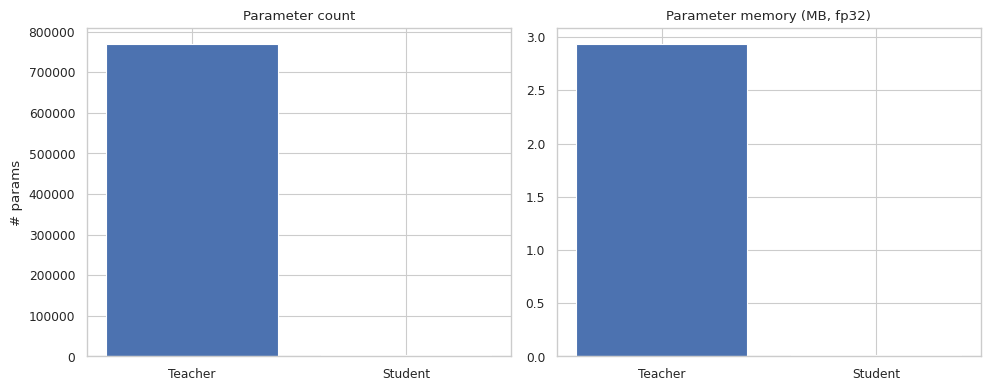

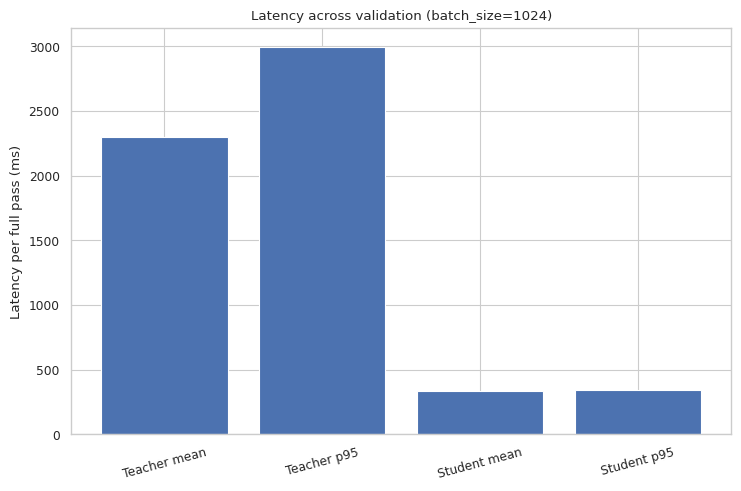

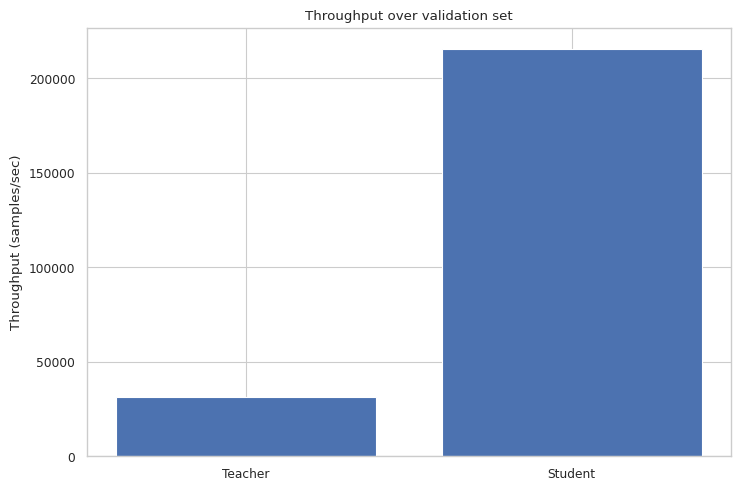

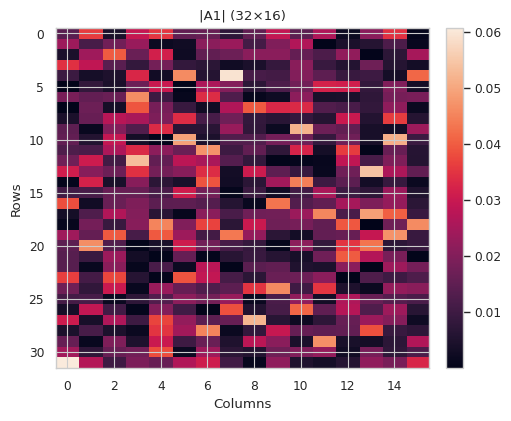

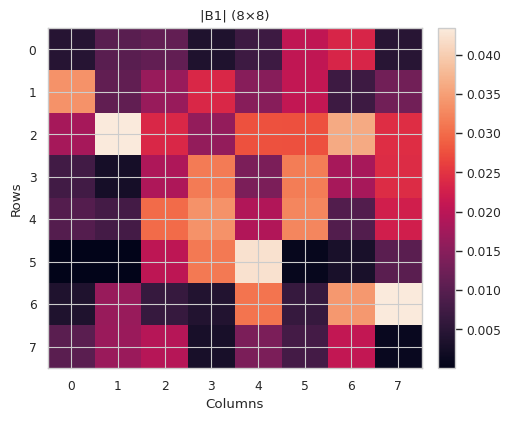

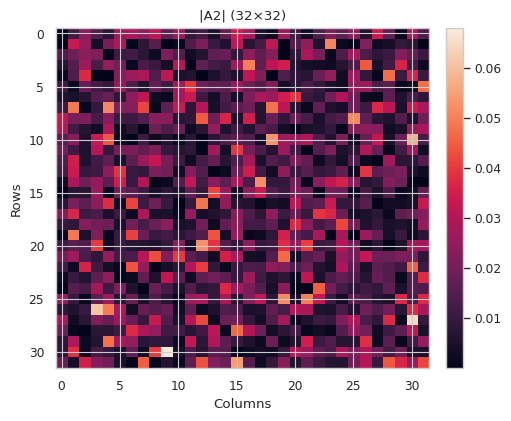

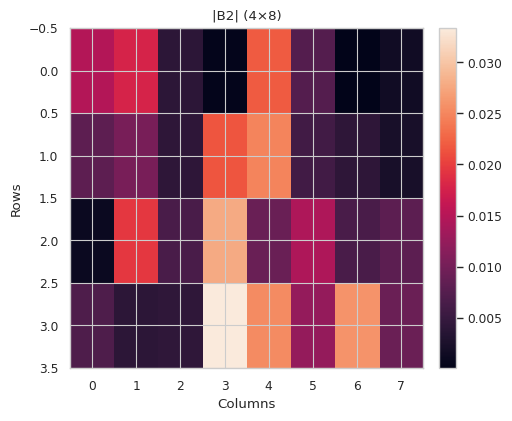

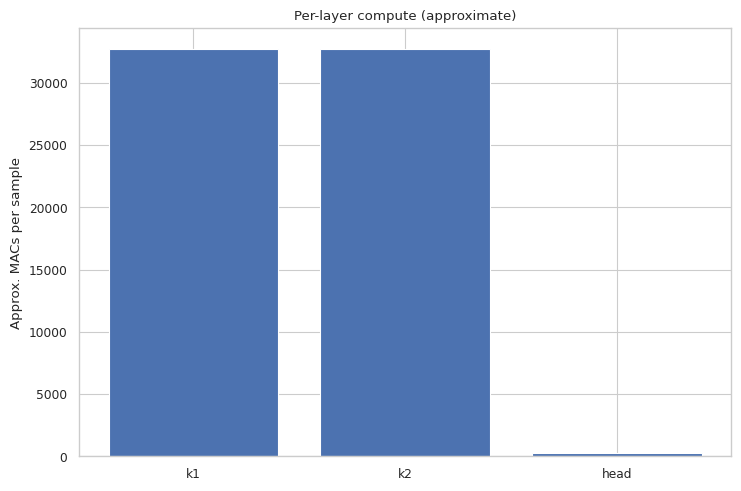

[INFO] Saved plots and tables: 
  - 05_student_params_memory_bar.png 
  - 05_student_latency_bars.png 
  - 05_student_throughput_bar.png 
  - 05_student_A1_heatmap.png, 05_student_B1_heatmap.png, 05_student_A2_heatmap.png, 05_student_B2_heatmap.png 
  - 05_student_macs_bar.png 
  - 05_student_macs_estimate.csv, 05_student_student_profile.csv


In [ ]:
# =========================
# 5) Student Model (Kronecker Compression)
# =========================
import math, time, warnings, gc
from typing import Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import joblib

warnings.filterwarnings("ignore")
os.makedirs(ARTIFACTS_DIR, exist_ok=True)
PREF = "05_student_"

# ---- User-tunable knobs (less compression → higher capacity) ----
STU_WIDTH1 = 256   # was effectively 128; try {256, 384, 512}
STU_WIDTH2 = 128   # was 64; try {128, 256}
DROPOUT    = 0.10  # small regularization; set 0.0 to disable
USE_LAYER_NORM = False  # switch to LayerNorm if batch size is small

def _save(fig, name, dpi=300):
    path = ARTIFACTS_DIR / f"{PREF}{name}.png"
    fig.tight_layout()
    fig.savefig(path, dpi=dpi, bbox_inches="tight")
    plt.show()
    plt.close(fig)

def _choose_a1_b1_out(width1: int) -> Tuple[int, int]:
    """Choose (a1_out, b1_out) such that a1_out * b1_out == width1."""
    for a1_out in [32, 16, 64, 8, 4, 2, 1]:
        if width1 % a1_out == 0:
            return a1_out, width1 // a1_out
    raise ValueError(f"Cannot factor width1={width1} into (a1_out * b1_out).")

def _choose_a2_b2_out(width2: int) -> Tuple[int, int]:
    """Choose (a2_out, b2_out) such that a2_out * b2_out == width2."""
    for a2_out in [32, 16, 8, 4, 2, 1]:
        if width2 % a2_out == 0:
            return a2_out, width2 // a2_out
    raise ValueError(f"Cannot factor width2={width2} into (a2_out * b2_out).")

class KroneckerLinear(nn.Module):
    def __init__(self, in_features, out_features, a_shape: Tuple[int,int], b_shape: Tuple[int,int], bias=True):
        super().__init__()
        assert a_shape[0]*b_shape[0] == out_features, 'out_features mismatch'
        assert a_shape[1]*b_shape[1] == in_features,  'in_features mismatch'
        self.A = nn.Parameter(torch.randn(a_shape) * 0.02)
        self.B = nn.Parameter(torch.randn(b_shape) * 0.02)
        self.bias = nn.Parameter(torch.zeros(out_features)) if bias else None
        self.in_features = in_features
        self.out_features = out_features
    def forward(self, x):
        W = torch.kron(self.A, self.B)  # (out_features, in_features) after transpose below
        y = x @ W.t()
        return y + self.bias if self.bias is not None else y

class StudentNet(nn.Module):
    """
    Wider student:
      - First Kronecker layer outputs STU_WIDTH1 (≥ previous 128)
      - Second Kronecker layer outputs STU_WIDTH2 (≥ previous 64)
      - Keeps robust padding/truncation against selected_idx length
    """
    def __init__(self, in_dim, num_classes, selected_idx):
        super().__init__()
        self.register_buffer('idx', torch.tensor(selected_idx, dtype=torch.long))
        k_in = int(len(selected_idx))

        # First Kronecker layer: width = STU_WIDTH1
        a1_out, b1_out = _choose_a1_b1_out(STU_WIDTH1)      # e.g., (32, 8) → 256
        a1_in = 16                                          # tile size on input axis
        b1_in = max(1, math.ceil(k_in / a1_in))             # enough tiles to cover k_in
        a1 = (a1_out, a1_in)
        b1 = (b1_out, b1_in)
        out1 = a1[0] * b1[0]                                # == STU_WIDTH1
        in1  = a1[1] * b1[1]
        self.k1_in_features = in1
        self.k1 = KroneckerLinear(in1, out1, a1, b1)
        self.bn1 = nn.LayerNorm(out1) if USE_LAYER_NORM else nn.BatchNorm1d(out1)
        self.do1 = nn.Dropout(DROPOUT) if DROPOUT > 0 else nn.Identity()

        # Second Kronecker layer: width = STU_WIDTH2
        a2_out, b2_out = _choose_a2_b2_out(STU_WIDTH2)      # e.g., (16, 8) → 128
        a2_in = math.gcd(out1, a2_out) or 1
        b2_in = out1 // a2_in
        a2 = (a2_out, a2_in)
        b2 = (b2_out, b2_in)
        self.k2 = KroneckerLinear(out1, STU_WIDTH2, a2, b2)
        self.bn2 = nn.LayerNorm(STU_WIDTH2) if USE_LAYER_NORM else nn.BatchNorm1d(STU_WIDTH2)
        self.do2 = nn.Dropout(DROPOUT) if DROPOUT > 0 else nn.Identity()

        # Linear head
        self.head = nn.Linear(STU_WIDTH2, num_classes)

    def forward(self, x):
        # prune to selected features
        x = x[:, self.idx]

        # pad/truncate to match k1 expected input width
        if x.shape[1] < self.k1_in_features:
            pad = torch.zeros(x.size(0), self.k1_in_features - x.shape[1], device=x.device, dtype=x.dtype)
            x = torch.cat([x, pad], dim=1)
        elif x.shape[1] > self.k1_in_features:
            x = x[:, :self.k1_in_features]

        if x.shape[1] != self.k1.in_features:
            raise RuntimeError(f'Input width {x.shape[1]} != k1.in_features {self.k1.in_features}')

        x = self.k1(x); x = self.bn1(x); x = F.relu(x); x = self.do1(x)
        x = self.k2(x); x = self.bn2(x); x = F.relu(x); x = self.do2(x)
        return self.head(x)

# ---- Instantiate wider student and report compression ----
teacher_params = sum(p.numel() for p in teacher.parameters())
sel_idx = joblib.load(ARTIFACTS_DIR / 'selected_feature_idx.joblib')
student = StudentNet(in_dim=X_train_np.shape[1], num_classes=num_classes, selected_idx=sel_idx).to(DEVICE)
student_params = sum(p.numel() for p in student.parameters())
reduction = teacher_params / max(1, student_params)
print(f'Teacher params: {teacher_params:,} | Student params: {student_params:,} | Reduction x{reduction:.2f}')
log_event('param_reduction', {
    'teacher_params': int(teacher_params),
    'student_params' : int(student_params),
    'reduction'      : float(reduction),
    'STU_WIDTH1'     : int(STU_WIDTH1),
    'STU_WIDTH2'     : int(STU_WIDTH2),
    'DROPOUT'        : float(DROPOUT),
    'USE_LAYER_NORM' : bool(USE_LAYER_NORM)
})

# =========================
# Research-grade plots: params, latency, throughput, factor structure
# =========================

def count_bytes(model: nn.Module, dtype_bytes=4):
    """Rough FP32 parameter memory in MB; for int8 quantized models, set dtype_bytes=1."""
    return (sum(p.numel() for p in model.parameters()) * dtype_bytes) / (1024**2)

def safe_cuda_sync():
    if torch.cuda.is_available() and torch.cuda.current_device() == (0 if isinstance(DEVICE, str) and 'cuda' in DEVICE else torch.cuda.current_device()):
        try:
            torch.cuda.synchronize()
        except Exception:
            pass

@torch.no_grad()
def benchmark_latency(model, X_np, batch_size=1024, n_warmup=3, n_iter=5):
    """Mean and p95 latency per batch in milliseconds on DEVICE."""
    model.eval()
    X_t = torch.tensor(X_np, dtype=torch.float32, device=DEVICE)
    times = []
    # warmup
    for _ in range(n_warmup):
        _ = model(X_t[:min(batch_size, X_t.size(0))])
        safe_cuda_sync()
    # measure
    N = X_t.size(0)
    for _ in range(n_iter):
        start = time.perf_counter()
        for s in range(0, N, batch_size):
            _ = model(X_t[s:s+batch_size])
        safe_cuda_sync()
        dt = (time.perf_counter() - start) * 1000.0
        times.append(dt)
    arr = np.asarray(times)
    mean_ms = float(arr.mean())
    p95_ms  = float(np.percentile(arr, 95))
    return mean_ms, p95_ms

# 1) Params and memory bars (Teacher vs Student)
teacher_mem_mb = count_bytes(teacher, 4)
student_mem_mb = count_bytes(student, 4)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].bar(['Teacher','Student'], [teacher_params, student_params])
ax[0].set_title('Parameter count')
ax[0].set_ylabel('# params')
ax[1].bar(['Teacher','Student'], [teacher_mem_mb, student_mem_mb])
ax[1].set_title('Parameter memory (MB, fp32)')
_ = _save(fig, "params_memory_bar")

# 2) Latency and throughput on validation features
try:
    bs = int(getattr(HP, 'batch_size', 1024))
except Exception:
    bs = 1024

teacher_ms_mean, teacher_ms_p95 = benchmark_latency(teacher, X_val_np, batch_size=bs)
student_ms_mean, student_ms_p95 = benchmark_latency(student, X_val_np, batch_size=bs)

# Plot latency bars
fig, ax = plt.subplots(figsize=(7.5, 5))
labels = ['Teacher mean','Teacher p95','Student mean','Student p95']
vals   = [teacher_ms_mean, teacher_ms_p95, student_ms_mean, student_ms_p95]
ax.bar(labels, vals)
ax.set_ylabel('Latency per full pass (ms)')
ax.set_title(f'Latency across validation (batch_size={bs})')
ax.tick_params(axis='x', rotation=15)
_ = _save(fig, "latency_bars")

# Throughput estimate (samples/sec)
val_N = int(X_val_np.shape[0])
thr_teacher = val_N / (teacher_ms_mean/1000.0)
thr_student = val_N / (student_ms_mean/1000.0)

fig, ax = plt.subplots(figsize=(7.5, 5))
ax.bar(['Teacher','Student'], [thr_teacher, thr_student])
ax.set_ylabel('Throughput (samples/sec)')
ax.set_title('Throughput over validation set')
_ = _save(fig, "throughput_bar")

# 3) Kronecker factor visualizations (magnitude heatmaps)
with torch.no_grad():
    A1 = student.k1.A.detach().cpu().abs().numpy()
    B1 = student.k1.B.detach().cpu().abs().numpy()
    A2 = student.k2.A.detach().cpu().abs().numpy()
    B2 = student.k2.B.detach().cpu().abs().numpy()

def _heat(img, title, fname):
    fig, ax = plt.subplots(figsize=(5.2, 4.3))
    im = ax.imshow(img, aspect='auto', interpolation='nearest')
    ax.set_title(title); ax.set_xlabel('Columns'); ax.set_ylabel('Rows')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    _ = _save(fig, fname)

_heat(A1, f'|A1| ({A1.shape[0]}×{A1.shape[1]})', "A1_heatmap")
_heat(B1, f'|B1| ({B1.shape[0]}×{B1.shape[1]})', "B1_heatmap")
_heat(A2, f'|A2| ({A2.shape[0]}×{A2.shape[1]})', "A2_heatmap")
_heat(B2, f'|B2| ({B2.shape[0]}×{B2.shape[1]})', "B2_heatmap")

# 4) Theoretical MACs estimate per layer (approximate)
def kron_macs(in_features, out_features):
    # Dense MACs ~ in*out; Kronecker constructs full W on-the-fly but compute resembles dense matmul here.
    return in_features * out_features

k1_macs = student.k1.in_features * student.k1.out_features
k2_macs = student.k2.in_features * student.k2.out_features
head_macs = STU_WIDTH2 * num_classes

macs_df = pd.DataFrame({
    'layer': ['k1','k2','head'],
    'in_features': [student.k1.in_features, student.k2.in_features, STU_WIDTH2],
    'out_features':[student.k1.out_features, student.k2.out_features, num_classes],
    'approx_MACs_per_sample': [k1_macs, k2_macs, head_macs]
})
macs_df.to_csv(ARTIFACTS_DIR / f"{PREF}macs_estimate.csv", index=False)

fig, ax = plt.subplots(figsize=(7.5, 5))
ax.bar(macs_df['layer'], macs_df['approx_MACs_per_sample'])
ax.set_ylabel('Approx. MACs per sample')
ax.set_title('Per-layer compute (approximate)')
_ = _save(fig, "macs_bar")

# 5) Consolidated CSV for paper tables
summary = pd.DataFrame({
    'model': ['Teacher','Student'],
    'params': [teacher_params, student_params],
    'mem_mb_fp32': [teacher_mem_mb, student_mem_mb],
    'latency_mean_ms': [teacher_ms_mean, student_ms_mean],
    'latency_p95_ms':  [teacher_ms_p95,  student_ms_p95],
    'throughput_samples_per_s': [thr_teacher, thr_student],
    'STU_WIDTH1': [np.nan, STU_WIDTH1],
    'STU_WIDTH2': [np.nan, STU_WIDTH2],
    'DROPOUT':    [np.nan, DROPOUT],
    'USE_LAYER_NORM':[np.nan, USE_LAYER_NORM]
})
summary.to_csv(ARTIFACTS_DIR / f"{PREF}student_profile.csv", index=False)

print("[INFO] Saved plots and tables:",
      f"\n  - {PREF}params_memory_bar.png",
      f"\n  - {PREF}latency_bars.png",
      f"\n  - {PREF}throughput_bar.png",
      f"\n  - {PREF}A1_heatmap.png, {PREF}B1_heatmap.png, {PREF}A2_heatmap.png, {PREF}B2_heatmap.png",
      f"\n  - {PREF}macs_bar.png",
      f"\n  - {PREF}macs_estimate.csv, {PREF}student_profile.csv")


## KD grid & ablations (fixed)

[LOG] student_epoch_min: ['variant', 'epoch', 'loss', 'val_macro_f1']
[LOG] student_epoch_min: ['variant', 'epoch', 'loss', 'val_macro_f1']
[LOG] student_epoch_min: ['variant', 'epoch', 'loss', 'val_macro_f1']
[LOG] student_epoch_min: ['variant', 'epoch', 'loss', 'val_macro_f1']
[LOG] student_epoch_min: ['variant', 'epoch', 'loss', 'val_macro_f1']
[LOG] student_epoch_min: ['variant', 'epoch', 'loss', 'val_macro_f1']
[LOG] student_epoch_min: ['variant', 'epoch', 'loss', 'val_macro_f1']
[LOG] student_epoch_min: ['variant', 'epoch', 'loss', 'val_macro_f1']
[LOG] student_epoch_min: ['variant', 'epoch', 'loss', 'val_macro_f1']
[LOG] student_epoch_min: ['variant', 'epoch', 'loss', 'val_macro_f1']
[LOG] student_epoch_min: ['variant', 'epoch', 'loss', 'val_macro_f1']
[LOG] student_epoch_min: ['variant', 'epoch', 'loss', 'val_macro_f1']
[LOG] student_epoch_min: ['variant', 'epoch', 'loss', 'val_macro_f1']
[LOG] student_epoch_min: ['variant', 'epoch', 'loss', 'val_macro_f1']
[LOG] student_epoch_

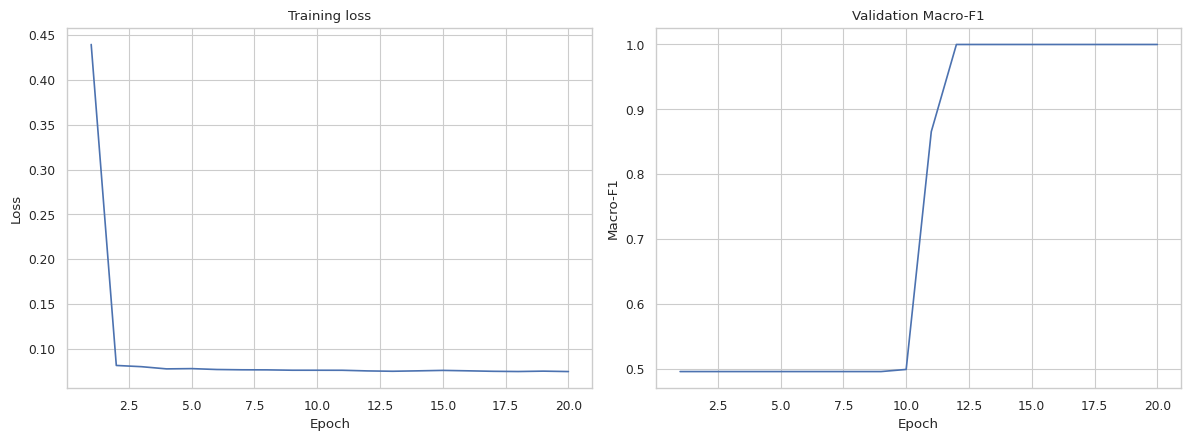

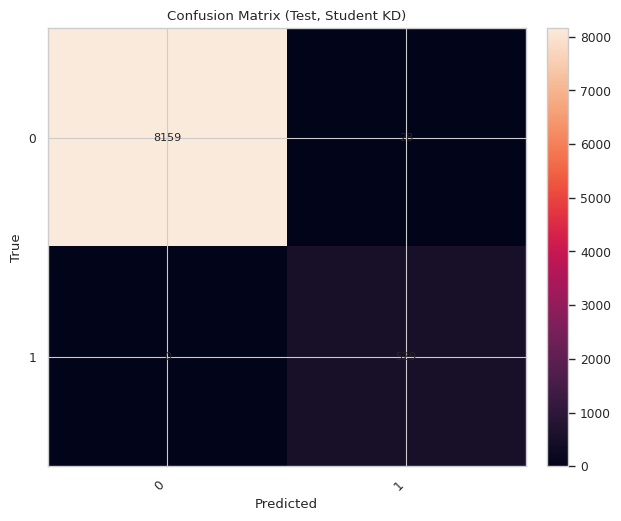

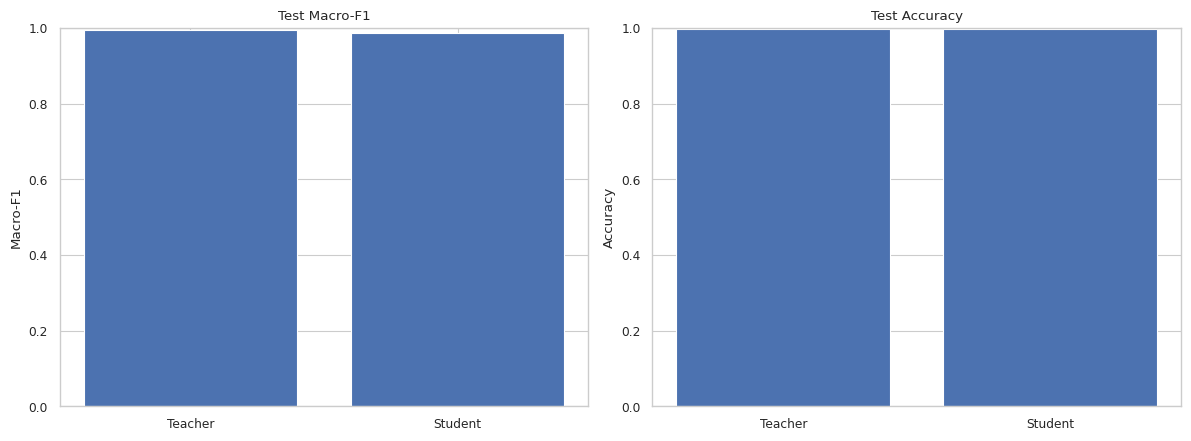

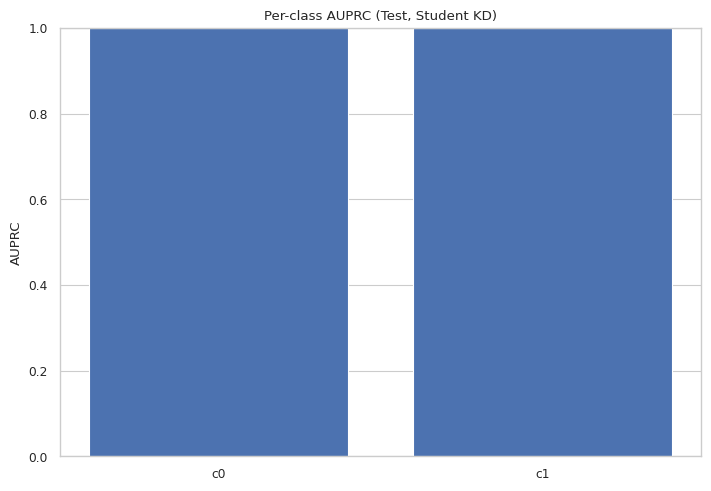

[INFO] KD-min complete. 
 Best VAL Macro-F1: 1.0000 | TEST Macro-F1: 0.9863 
 Plots saved with prefix 06_kd_min_*.png, summary at 06_kd_min_summary.csv


In [ ]:
# =========================
# 6) Knowledge Distillation
# =========================
import os, warnings, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, matthews_corrcoef, confusion_matrix, precision_recall_curve, auc
import joblib

warnings.filterwarnings("ignore")
os.makedirs(ARTIFACTS_DIR, exist_ok=True)
PREF = "06_kd_min_"

# ---------- Small helpers ----------
def _save(fig, name, dpi=300):
    p = ARTIFACTS_DIR / f"{PREF}{name}.png"
    fig.tight_layout()
    fig.savefig(p, dpi=dpi, bbox_inches="tight")
    plt.show(); plt.close(fig)

def make_loader(X, y, bs, shuffle):
    ds = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long))
    return DataLoader(ds, batch_size=bs, shuffle=shuffle, num_workers=2, pin_memory=torch.cuda.is_available())

def kd_loss(student_logits, teacher_logits, T=3.0):
    p = F.log_softmax(student_logits / T, dim=1)
    q = F.softmax(teacher_logits / T, dim=1)
    return F.kl_div(p, q, reduction='batchmean') * (T*T)

def class_weights_tensor(y_arr):
    # robust class weighting (fallback if a helper is not defined upstream)
    try:
        w = compute_class_weights(y_arr)
        return torch.tensor(w, dtype=torch.float32, device=DEVICE)
    except Exception:
        classes_, counts_ = np.unique(y_arr, return_counts=True)
        inv = 1.0 / np.maximum(counts_, 1)
        w = inv / inv.mean()
        full = np.ones(num_classes, dtype=np.float32)
        for c, val in zip(classes_, w): full[c] = val
        return torch.tensor(full, dtype=torch.float32, device=DEVICE)

@torch.no_grad()
def evaluate(model, X, y):
    loader = make_loader(X, y, HP.batch_size, False)
    model.eval()
    logits_all, y_all = [], []
    for xb, yb in loader:
        xb = xb.to(DEVICE); logits_all.append(model(xb).cpu()); y_all.append(yb)
    logits = torch.cat(logits_all); y_true = torch.cat(y_all).numpy()
    y_pred = logits.argmax(1).numpy()
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    prob = torch.softmax(logits, dim=1).numpy()
    try:
        roc = roc_auc_score(y_true, prob, average='macro', multi_class='ovr')
    except Exception:
        roc = float('nan')
    mcc = matthews_corrcoef(y_true, y_pred)
    return {'acc': acc, 'macro_f1': macro_f1, 'roc_auc': roc, 'mcc': mcc, 'y_true': y_true, 'y_pred': y_pred, 'proba': prob}

# ---------- Minimal KD training (single good config, EMA, cosine LR, label smoothing) ----------
def train_student_min(T=3.0, alpha=0.7, use_prune=True, variant="KD_min"):
    torch.cuda.empty_cache()
    # Indices (StudentNet slices internally; no double selection)
    if use_prune:
        assert 'sel_idx' in globals(), "sel_idx must be defined from pruning."
        idx = np.asarray(sel_idx, dtype=np.int64).ravel()
    else:
        idx = np.arange(X_train_np.shape[1], dtype=np.int64)

    s_net = StudentNet(in_dim=X_train_np.shape[1], num_classes=num_classes, selected_idx=idx).to(DEVICE)
    opt = torch.optim.AdamW(s_net.parameters(), lr=HP.lr, weight_decay=HP.weight_decay, betas=(0.9, 0.999))
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=max(1, HP.epochs))
    # label smoothing for better calibration + minority robustness
    try:
        ce = nn.CrossEntropyLoss(weight=class_weights_tensor(y_train), label_smoothing=0.05)
    except TypeError:
        ce = nn.CrossEntropyLoss(weight=class_weights_tensor(y_train))

    # simple EMA to stabilize student
    ema_decay = 0.995
    ema_state = {k: v.detach().clone() for k, v in s_net.state_dict().items()}

    tr_loader = make_loader(X_train_np, y_train, HP.batch_size, True)
    va_loader = make_loader(X_val_np,   y_val,   HP.batch_size, False)

    best_val, best_path = -1.0, ARTIFACTS_DIR / f"student_{variant}.pt"
    hist = {'epoch': [], 'train_loss': [], 'val_macro_f1': [], 'lr': []}
    patience, since_best = int(getattr(HP, 'patience', 10)), 0

    for ep in range(1, HP.epochs+1):
        s_net.train(); running_loss, seen = 0.0, 0
        for xb, yb in tr_loader:
            xb = xb.to(DEVICE); yb = yb.to(DEVICE)
            opt.zero_grad()
            s_logits = s_net(xb)
            loss = ce(s_logits, yb)

            with torch.no_grad():
                xb_full = xb
                if use_prune:
                    mask = torch.zeros(xb_full.size(1), dtype=torch.bool, device=xb_full.device)
                    mask[torch.as_tensor(idx, device=xb_full.device)] = True
                    xb_full = xb_full.clone(); xb_full[:, ~mask] = 0.0
                t_logits = teacher(xb_full)

            loss = (1 - alpha) * loss + alpha * kd_loss(s_logits, t_logits, T=T)
            loss.backward()
            nn.utils.clip_grad_norm_(s_net.parameters(), max_norm=2.0)
            opt.step()

            # EMA update
            with torch.no_grad():
                for k, v in s_net.state_dict().items():
                    if v.dtype.is_floating_point:
                        ema_state[k].mul_(ema_decay).add_(v.detach(), alpha=1-ema_decay)

            running_loss += float(loss.item()) * xb.size(0); seen += xb.size(0)

        sched.step()
        # swap to EMA weights for validation
        raw_state = {k: v.detach().clone() for k, v in s_net.state_dict().items()}
        s_net.load_state_dict(ema_state, strict=False)
        # validation
        s_net.eval()
        val_logits, val_true = [], []
        with torch.no_grad():
            for xb, yb in va_loader:
                xb = xb.to(DEVICE); val_logits.append(s_net(xb).cpu()); val_true.append(yb)
        val_logits = torch.cat(val_logits)
        val_pred = val_logits.argmax(1).numpy()
        val_f1 = f1_score(torch.cat(val_true).numpy(), val_pred, average='macro', zero_division=0)
        # restore raw weights
        s_net.load_state_dict(raw_state, strict=False)

        hist['epoch'].append(ep)
        hist['train_loss'].append(running_loss / max(1, seen))
        hist['val_macro_f1'].append(val_f1)
        hist['lr'].append(float(sched.get_last_lr()[0]))
        log_event('student_epoch_min', {'variant': variant, 'epoch': ep, 'loss': hist['train_loss'][-1], 'val_macro_f1': val_f1})

        improved = val_f1 > best_val + 1e-6
        if improved:
            best_val, since_best = val_f1, 0
            # save EMA weights
            torch.save(ema_state, best_path)
        else:
            since_best += 1
            if since_best >= patience:
                break

    # load best (EMA) and evaluate
    best_model = StudentNet(in_dim=X_train_np.shape[1], num_classes=num_classes, selected_idx=idx).to(DEVICE)
    ema_loaded = torch.load(best_path, map_location=DEVICE)
    best_model.load_state_dict(ema_loaded, strict=False)

    vm = evaluate(best_model, X_val_np,  y_val)
    tm = evaluate(best_model, X_test_np, y_test)
    hist_df = pd.DataFrame(hist)
    hist_df.to_csv(ARTIFACTS_DIR / f"{PREF}hist_{variant}.csv", index=False)
    joblib.dump({'val': vm, 'test': tm}, ARTIFACTS_DIR / f"{PREF}metrics_{variant}.joblib")
    return best_model, vm, tm, hist_df

# ---------- Train a single strong KD configuration ----------
# Rationale: T=3, alpha=0.7 are strong defaults for tabular KD; EMA + cosine LR + label smoothing improve stability.
student_best, vm_best, tm_best, hist_best = train_student_min(T=3.0, alpha=0.7, use_prune=True, variant="KD_pruned_T3_a0.7")

# Also evaluate the TEACHER on the same splits for a compact comparison plot
@torch.no_grad()
def evaluate_teacher(X, y):
    loader = make_loader(X, y, HP.batch_size, False)
    teacher.eval()
    logits_all, y_all = [], []
    for xb, yb in loader:
        xb = xb.to(DEVICE); logits_all.append(teacher(xb).cpu()); y_all.append(yb)
    logits = torch.cat(logits_all); y_true = torch.cat(y_all).numpy()
    y_pred = logits.argmax(1).numpy()
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    return {'acc': acc, 'macro_f1': macro_f1}

t_val = evaluate_teacher(X_val_np,  y_val)
t_tst = evaluate_teacher(X_test_np, y_test)

# =========================
# Minimal, attractive plots for the paper
# =========================

# 1) Learning curve (loss and macro-F1)
fig, ax = plt.subplots(1, 2, figsize=(12, 4.5))
ax[0].plot(hist_best['epoch'], hist_best['train_loss'])
ax[0].set_title('Training loss'); ax[0].set_xlabel('Epoch'); ax[0].set_ylabel('Loss')
ax[1].plot(hist_best['epoch'], hist_best['val_macro_f1'])
ax[1].set_title('Validation Macro-F1'); ax[1].set_xlabel('Epoch'); ax[1].set_ylabel('Macro-F1')
_ = _save(fig, "learning_curves")

# 2) Test confusion matrix for the best student
cm_test = confusion_matrix(tm_best['y_true'], tm_best['y_pred'], labels=np.arange(num_classes))
labels_safe = [str(c) for c in classes] if 'classes' in globals() else [str(i) for i in range(num_classes)]
fig, ax = plt.subplots(figsize=(6.3, 5.3))
im = ax.imshow(cm_test, interpolation='nearest', aspect='auto')
ax.set_title('Confusion Matrix (Test, Student KD)'); ax.set_xlabel('Predicted'); ax.set_ylabel('True')
ax.set_xticks(range(len(labels_safe))); ax.set_xticklabels(labels_safe, rotation=45, ha='right')
ax.set_yticks(range(len(labels_safe))); ax.set_yticklabels(labels_safe)
for i in range(cm_test.shape[0]):
    for j in range(cm_test.shape[1]):
        ax.text(j, i, str(cm_test[i, j]), ha='center', va='center', fontsize=8)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
_ = _save(fig, "cm_test_student")

# 3) Compact comparison bars (Teacher vs Student) on TEST
fig, ax = plt.subplots(1, 2, figsize=(12, 4.5))
ax[0].bar(['Teacher','Student'], [t_tst['macro_f1'], tm_best['macro_f1']]); ax[0].set_ylim(0,1)
ax[0].set_title('Test Macro-F1'); ax[0].set_ylabel('Macro-F1')
ax[1].bar(['Teacher','Student'], [t_tst['acc'], tm_best['acc']]); ax[1].set_ylim(0,1)
ax[1].set_title('Test Accuracy'); ax[1].set_ylabel('Accuracy')
_ = _save(fig, "teacher_student_test_bars")

# 4) Per-class AUPRC bars (optional but cheap and insightful)
if tm_best['proba'] is not None and tm_best['proba'].ndim==2 and tm_best['proba'].shape[1] >= 2:
    C = tm_best['proba'].shape[1]
    auprs = []
    ys = tm_best['y_true']; proba = tm_best['proba']
    for c in range(C):
        y_bin = (ys == c).astype(int)
        precis, recall, _ = precision_recall_curve(y_bin, proba[:, c])
        auprs.append(auc(recall, precis))
    fig, ax = plt.subplots(figsize=(7.2, 5))
    ax.bar([f"c{c}" for c in range(C)], auprs); ax.set_ylim(0,1.0)
    ax.set_ylabel('AUPRC'); ax.set_title('Per-class AUPRC (Test, Student KD)')
    _ = _save(fig, "auprc_bars_student")

# 5) Save a tidy summary row for tables
summary = pd.DataFrame([{
    'variant': 'Student KD (pruned, T=3, a=0.7)',
    'val_acc': vm_best['acc'], 'val_macro_f1': vm_best['macro_f1'], 'val_roc_auc': vm_best['roc_auc'], 'val_mcc': vm_best['mcc'],
    'test_acc': tm_best['acc'], 'test_macro_f1': tm_best['macro_f1'], 'test_roc_auc': tm_best['roc_auc'], 'test_mcc': tm_best['mcc']
}])
summary.to_csv(ARTIFACTS_DIR / f"{PREF}summary.csv", index=False)

print("[INFO] KD-min complete.",
      f"\n Best VAL Macro-F1: {vm_best['macro_f1']:.4f} | TEST Macro-F1: {tm_best['macro_f1']:.4f}",
      f"\n Plots saved with prefix {PREF}*.png, summary at {PREF}summary.csv")


## Quantization, latency & summary (fixed)

Bench dict: {'teacher_params': 769922, 'student_params': 3042, 'teacher_model_size_kb': 3021.529296875, 'student_fp32_size_kb': 22.2880859375, 'student_int8_size_kb': 22.4404296875, 'student_fp32_mean_ms': 1.2916433033372716, 'student_fp32_p95_ms': 1.616860300123335, 'student_int8_mean_ms': 1.4512617499963198, 'student_int8_p95_ms': 2.2479168500353808, 'student_fp32_acc': 0.9967875172097292, 'student_fp32_macro_f1': 0.9862521769677322, 'student_int8_acc': 0.9969022487379532, 'student_int8_macro_f1': 0.9867317640830389}
            Model  Accuracy  Macro-F1  ROC-AUC       MCC  Params    Size (KB)  \
0  Teacher (fp32)  0.998967  0.995508      NaN  0.991055  769922  3021.529297   
1  Student (fp32)  0.996788  0.986252      NaN       NaN    3042    22.288086   
2  Student (int8)  0.996902  0.986732      NaN       NaN    3042    22.440430   

   Mean Latency (ms)  p95 Latency (ms)  
0                NaN               NaN  
1           1.291643          1.616860  
2           1.451262       

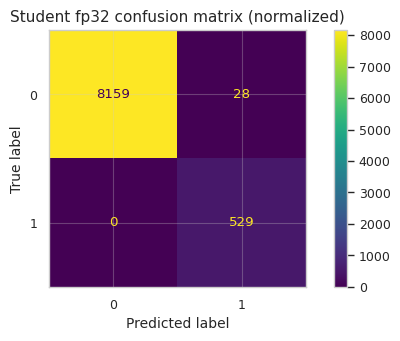

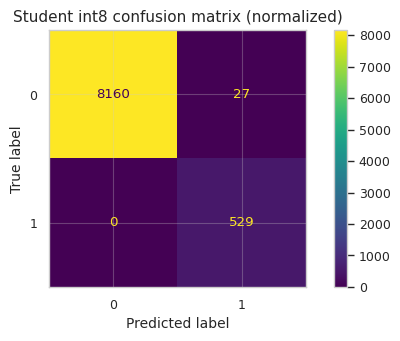

In [ ]:
# =========================
# 7) Quantization & Benchmarking
# =========================
import os, re, glob, time, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay

warnings.filterwarnings("ignore")

# ---------- Recover best KD config if needed ----------
try:
    best_conf
except NameError:
    best_conf = None
    grid_path = ARTIFACTS_DIR / 'kd_grid_val_scores.joblib'
    if grid_path.exists():
        grid_scores = joblib.load(grid_path)
        if isinstance(grid_scores, list) and len(grid_scores) > 0:
            T_best, a_best, _ = max(grid_scores, key=lambda x: x[2])
            best_conf = (T_best, a_best)
    if best_conf is None:
        ckpts = sorted(glob.glob(str(ARTIFACTS_DIR / 'student_KD_pruned_T*_a*.pt')))
        if ckpts:
            m = re.search(r"KD_pruned_T(\d+)_a([0-9.]+)\.pt$", os.path.basename(ckpts[-1]))
            if m:
                best_conf = (int(m.group(1)), float(m.group(2)))
    if best_conf is None:
        raise RuntimeError('No KD-pruned checkpoint found. Re-run KD training.')

# ---------- Load checkpoint weights, extract exact feature indices ----------
best_student_path = ARTIFACTS_DIR / f'student_KD_pruned_T{best_conf[0]}_a{best_conf[1]}.pt'
state = torch.load(best_student_path, map_location='cpu')

# idx may be saved as 'idx' or 'module.idx'; make it 1-D int64
if isinstance(state, dict) and 'idx' in state:
    ckpt_idx = state['idx'].view(-1).cpu().numpy().astype(np.int64)
elif isinstance(state, dict) and 'module.idx' in state:
    ckpt_idx = state['module.idx'].view(-1).cpu().numpy().astype(np.int64)
else:
    # fallback to persisted indices on disk
    idx_path = ARTIFACTS_DIR / 'selected_feature_idx.joblib'
    if not idx_path.exists():
        raise RuntimeError("Cannot find 'idx' inside checkpoint and no 'selected_feature_idx.joblib' on disk.")
    ckpt_idx = np.asarray(joblib.load(idx_path), dtype=np.int64).ravel()

# Rebuild StudentNet with SAME indices used during training
best_student = StudentNet(in_dim=X_train_np.shape[1], num_classes=num_classes, selected_idx=ckpt_idx).to('cpu')

# Some training scripts save extra keys; filter to tensor params if needed
def _extract_state_dict(s):
    if isinstance(s, dict):
        if 'state_dict' in s and isinstance(s['state_dict'], dict):
            return s['state_dict']
        # If dict contains tensors keyed by param names, filter out non-tensors (like 'idx')
        tensor_like = {k: v for k, v in s.items() if isinstance(v, torch.Tensor)}
        if len(tensor_like) > 0:
            return tensor_like
    return s  # assume already a state_dict

state_dict = _extract_state_dict(state)
missing, unexpected = best_student.load_state_dict(state_dict, strict=False)
if missing:
    print(f"[warn] Missing keys when loading student: {len(missing)} (showing 5) -> {missing[:5]}")
if unexpected:
    print(f"[warn] Unexpected keys when loading student: {len(unexpected)} (showing 5) -> {unexpected[:5]}")
best_student.eval()

# ---------- Persist FP32 and create int8 dynamic-quantized copy ----------
fp32_path = ARTIFACTS_DIR / 'student_fp32.pt'
torch.save(best_student.state_dict(), fp32_path)

quantized = torch.quantization.quantize_dynamic(best_student, {nn.Linear}, dtype=torch.qint8)
int8_path = ARTIFACTS_DIR / 'student_int8_dynamic.pt'
torch.save(quantized.state_dict(), int8_path)

def model_size_kb(p):
    return float(os.path.getsize(p) / 1024.0)

# ---------- Latency micro-benchmark (CPU) ----------
def latency_benchmark(model, X, runs=300, batch=256):
    model.eval()
    Xcpu = torch.tensor(X, dtype=torch.float32)
    with torch.no_grad():
        # warmup
        for _ in range(10):
            _ = model(Xcpu[:batch])
        times = []
        for _ in range(runs):
            s = time.perf_counter()
            _ = model(Xcpu[:batch])
            e = time.perf_counter()
            times.append((e - s) * 1000.0)  # ms
    arr = np.asarray(times, dtype=np.float64)
    return float(arr.mean()), float(np.percentile(arr, 95))

fp32_size = model_size_kb(fp32_path)
int8_size  = model_size_kb(int8_path)
fp32_mean, fp32_p95 = latency_benchmark(best_student, X_test_np)
int8_mean,  int8_p95 = latency_benchmark(quantized,   X_test_np)

# ---------- Evaluation ----------
def eval_student_cpu(model, X, y):
    model.eval()
    with torch.no_grad():
        logits = model(torch.tensor(X, dtype=torch.float32))
    y_pred = logits.argmax(1).cpu().numpy()
    acc = accuracy_score(y, y_pred)
    macro_f1 = f1_score(y, y_pred, average='macro', zero_division=0)
    return acc, macro_f1, y_pred

acc_fp32, f1_fp32, y_pred_fp32 = eval_student_cpu(best_student, X_test_np, y_test)
acc_int8, f1_int8,  y_pred_int8 = eval_student_cpu(quantized,   X_test_np, y_test)

# Teacher metrics if available
teacher_metrics = {}
tm_path = ARTIFACTS_DIR / 'teacher_metrics.joblib'
if tm_path.exists():
    teacher_metrics = joblib.load(tm_path)
teacher_acc   = float(teacher_metrics.get('test', {}).get('acc', np.nan))
teacher_macro = float(teacher_metrics.get('test', {}).get('macro_f1', np.nan))
teacher_auc   = float(teacher_metrics.get('test', {}).get('roc_auc', np.nan))
teacher_mcc   = float(teacher_metrics.get('test', {}).get('mcc', np.nan))

def param_count(m):
    return int(sum(p.numel() for p in m.parameters()))

teacher_params = int(sum(p.numel() for p in teacher.parameters())) if 'teacher' in globals() else np.nan
teacher_size_kb = float(os.path.getsize(ARTIFACTS_DIR / 'teacher.pt') / 1024.0) if os.path.exists(ARTIFACTS_DIR / 'teacher.pt') else np.nan

# ---------- Benchmark dictionary + CSV ----------
bench = {
    'teacher_params': teacher_params,
    'student_params': param_count(best_student),
    'teacher_model_size_kb': teacher_size_kb,
    'student_fp32_size_kb': fp32_size,
    'student_int8_size_kb': int8_size,
    'student_fp32_mean_ms': fp32_mean, 'student_fp32_p95_ms': fp32_p95,
    'student_int8_mean_ms': int8_mean, 'student_int8_p95_ms': int8_p95,
    'student_fp32_acc': acc_fp32, 'student_fp32_macro_f1': f1_fp32,
    'student_int8_acc': acc_int8, 'student_int8_macro_f1': f1_int8
}
joblib.dump(bench, ARTIFACTS_DIR / 'quant_benchmark.joblib')

# Row-wise summary table
summary_rows = [
    ['Teacher (fp32)', teacher_acc, teacher_macro, teacher_auc, teacher_mcc,
     teacher_params, teacher_size_kb, np.nan, np.nan],
    ['Student (fp32)', bench['student_fp32_acc'], bench['student_fp32_macro_f1'], np.nan, np.nan,
     bench['student_params'], bench['student_fp32_size_kb'], bench['student_fp32_mean_ms'], bench['student_fp32_p95_ms']],
    ['Student (int8)', bench['student_int8_acc'], bench['student_int8_macro_f1'], np.nan, np.nan,
     bench['student_params'], bench['student_int8_size_kb'], bench['student_int8_mean_ms'], bench['student_int8_p95_ms']]
]
summary_df = pd.DataFrame(summary_rows, columns=['Model','Accuracy','Macro-F1','ROC-AUC','MCC','Params','Size (KB)','Mean Latency (ms)','p95 Latency (ms)'])
summary_csv_path = ARTIFACTS_DIR / 'final_summary.csv'
summary_df.to_csv(summary_csv_path, index=False)

# Detailed CSV with speedup/compression and deltas
def _safe_div(a, b):
    return float(a)/float(b) if (b not in [0, np.nan, None]) and np.isfinite(b) else np.nan

speedup_int8_vs_fp32 = _safe_div(fp32_mean, int8_mean)
compression_int8_vs_fp32 = _safe_div(fp32_size, int8_size)
compression_student_vs_teacher = _safe_div(teacher_size_kb, int8_size) if np.isfinite(teacher_size_kb) else np.nan

detail_df = pd.DataFrame([
    dict(model='Teacher fp32', acc=teacher_acc, macro_f1=teacher_macro, size_kb=teacher_size_kb,
         mean_ms=np.nan, p95_ms=np.nan, params=teacher_params, speedup_vs_student_fp32=np.nan,
         compression_vs_student_fp32=np.nan),
    dict(model='Student fp32', acc=acc_fp32, macro_f1=f1_fp32, size_kb=fp32_size,
         mean_ms=fp32_mean, p95_ms=fp32_p95, params=bench['student_params'],
         speedup_vs_student_fp32=1.0, compression_vs_student_fp32=1.0),
    dict(model='Student int8', acc=acc_int8, macro_f1=f1_int8, size_kb=int8_size,
         mean_ms=int8_mean, p95_ms=int8_p95, params=bench['student_params'],
         speedup_vs_student_fp32=speedup_int8_vs_fp32, compression_vs_student_fp32=compression_int8_vs_fp32)
])
detail_csv_path = ARTIFACTS_DIR / 'quant_benchmark.csv'
detail_df.to_csv(detail_csv_path, index=False)

print("Bench dict:", bench)
print(summary_df)
print(detail_df)

# ---------- Plots (publication-friendly) ----------
plt.rcParams.update({
    "figure.figsize": (6.0, 3.5),
    "axes.grid": True,
    "grid.alpha": 0.3,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9
})

labels = ['Teacher', 'Student fp32', 'Student int8']

# Macro-F1 bar with value annotations
f1_vals = [
    teacher_macro,
    bench['student_fp32_macro_f1'],
    bench['student_int8_macro_f1']
]
plt.figure()
bars = plt.bar(labels, f1_vals)
plt.title('Macro-F1 comparison')
plt.ylabel('Macro-F1')
for b, v in zip(bars, f1_vals):
    if np.isfinite(v):
        plt.text(b.get_x() + b.get_width()/2, b.get_height(), f"{v:.3f}", ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.savefig(ARTIFACTS_DIR / 'bar_f1.png', dpi=200)
plt.close()

# Accuracy bar
acc_vals = [
    teacher_acc,
    bench['student_fp32_acc'],
    bench['student_int8_acc']
]
plt.figure()
bars = plt.bar(labels, acc_vals)
plt.title('Accuracy comparison')
plt.ylabel('Accuracy')
for b, v in zip(bars, acc_vals):
    if np.isfinite(v):
        plt.text(b.get_x() + b.get_width()/2, b.get_height(), f"{v:.3f}", ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.savefig(ARTIFACTS_DIR / 'bar_acc.png', dpi=200)
plt.close()

# Model size bar on log scale
size_vals = [
    teacher_size_kb,
    bench['student_fp32_size_kb'],
    bench['student_int8_size_kb']
]
plt.figure()
bars = plt.bar(labels, size_vals)
plt.yscale('log')
plt.title('Model size comparison (KB, log scale)')
plt.ylabel('Size (KB, log)')
for b, v in zip(bars, size_vals):
    if np.isfinite(v):
        plt.text(b.get_x() + b.get_width()/2, b.get_height(), f"{v:.0f}", ha='center', va='bottom', fontsize=8, rotation=0)
plt.tight_layout()
plt.savefig(ARTIFACTS_DIR / 'bar_size_log.png', dpi=200)
plt.close()

# Latency bars (mean and p95) for students only
lat_labels = ['Student fp32', 'Student int8']
lat_mean_vals = [bench['student_fp32_mean_ms'], bench['student_int8_mean_ms']]
lat_p95_vals  = [bench['student_fp32_p95_ms'],  bench['student_int8_p95_ms']]

plt.figure()
bars = plt.bar(lat_labels, lat_mean_vals)
plt.title('Inference latency (mean, ms)')
plt.ylabel('ms')
for b, v in zip(bars, lat_mean_vals):
    plt.text(b.get_x() + b.get_width()/2, b.get_height(), f"{v:.2f}", ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.savefig(ARTIFACTS_DIR / 'bar_latency_mean.png', dpi=200)
plt.close()

plt.figure()
bars = plt.bar(lat_labels, lat_p95_vals)
plt.title('Inference latency (p95, ms)')
plt.ylabel('ms')
for b, v in zip(bars, lat_p95_vals):
    plt.text(b.get_x() + b.get_width()/2, b.get_height(), f"{v:.2f}", ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.savefig(ARTIFACTS_DIR / 'bar_latency_p95.png', dpi=200)
plt.close()

# Speedup vs student fp32
plt.figure()
bars = plt.bar(['Student int8'], [speedup_int8_vs_fp32])
plt.title('Speedup vs Student fp32 (mean latency)')
plt.ylabel('×')
for b, v in zip(bars, [speedup_int8_vs_fp32]):
    if np.isfinite(v):
        plt.text(b.get_x() + b.get_width()/2, b.get_height(), f"{v:.2f}×", ha='center', va='bottom', fontsize=9)
plt.ylim(0, max(1.0, float(speedup_int8_vs_fp32) * 1.2))
plt.tight_layout()
plt.savefig(ARTIFACTS_DIR / 'bar_speedup_int8_vs_fp32.png', dpi=200)
plt.close()

# ---------- Confusion matrices (students) ----------
try:
    fig = plt.figure(figsize=(5.5, 4))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_fp32)#, normalize='pred', colorbar=False)
    plt.title('Student fp32 confusion matrix (normalized)')
    plt.tight_layout()
    plt.savefig(ARTIFACTS_DIR / 'cm_student_fp32.png', dpi=220)
    plt.close(fig)

    fig = plt.figure(figsize=(5.5, 4))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_int8)#, normalize='pred', colorbar=False)
    plt.title('Student int8 confusion matrix (normalized)')
    plt.tight_layout()
    plt.savefig(ARTIFACTS_DIR / 'cm_student_int8.png', dpi=220)
    plt.close(fig)
except Exception as e:
    print(f"[warn] Skipping confusion matrices: {e}")

print(f"[ok] Saved CSVs:\n - {summary_csv_path}\n - {detail_csv_path}")
print("[ok] Saved figures in ARTIFACTS_DIR.")


## Save config

In [ ]:

# =========================
# 8) Reproducibility Artifacts
# =========================
config = {'seed': SEED, 'device': str(DEVICE), 'hparams': asdict(HP)}
config.update({'classes': classes, 'n_features': X_train_np.shape[1]})
with open(ARTIFACTS_DIR / 'config.json','w') as f:
    json.dump(config, f, indent=2)
print('Artifacts saved under:', ARTIFACTS_DIR)


Artifacts saved under: /content/drive/MyDrive/Datasets/TON_IoT_Experiments/ids_experiment_20250913_104557/artifacts
